In [1]:
import nltk
import nltk.data
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_excel('TaggedData.xlsx', sheet_name='FlatData_highFreq')
X, y=df['Comment'], df['TagClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [4]:
def clean_comments(comment, remove_stopwords = True):
    """Helper function to clean the comments i.e. to convert a document to a sequence of words.
     Please note that we're not removing stopwords since word2vec relies on the broader context
     of the sentence in order to produce high-quality word vectors.

     Arg: comment: comment string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: clean_comment : Cleaned comment (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    # 1. Remove HTML
    comment_text = BeautifulSoup(comment).get_text()
    #
    # 2. Remove non-letters
    comment_text = re.sub("[^a-zA-Z0-9]"," ", comment_text)
    #
    # 3. Convert words to lower case and split them
    clean_comment = comment_text.lower().split()
    #
    # 4. Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        clean_comment = [w for w in clean_comment if not w in stops]

    return clean_comment

In [5]:
def comment_to_sentences( comment: str, tokenizer: nltk.tokenize.punkt.PunktSentenceTokenizer ):
    """Helper function to split a comment into parsed sentences. Returns a
     list of sentences, where each sentence is a list of words.

     Arg: comment: comment string (str)
          tokenizer: punkt tokenizer
     Returns:
          comment_sentences: List of list of tokens.
                            e.g. [["word2vec", "was", "introduced", "by", "google" ],["it","leverages","distributed","token","representations"]]

     You should carry out the following steps.
     1. Use the tokenizer to split the paragraph into sentences.
     2. Clean the sentence to return a list of words for each sentence using the helper funtion above.
     3. Return a list of tokenized sentences.
    """
    ### Add your code here.
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(comment.strip())
    #
    # 2. Loop over each sentence
    comment_sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call comment_to_wordlist to get a list of words
            comment_sentences.append(clean_comments(raw_sentence))

    return comment_sentences

In [6]:
sentences = []
for comment in X_train:
  a=comment_to_sentences(comment, tokenizer)
  sentences += a

## 1.1. Approach 1: Using "bag of centroids" approach

In [7]:
from gensim.models import FastText

def generate_z(sentences):
    model = FastText(sentences, vector_size=100, window=5, workers=4,sg=1)
    word_list = list(model.wv.key_to_index.keys())
    z=np.array([model.wv[word] for word in word_list])
    return model, z, word_list

In [8]:
model, z, word_list = generate_z(sentences)

### 1.1.1. Choosing Optimum number of clusters for "bag of centroids"

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

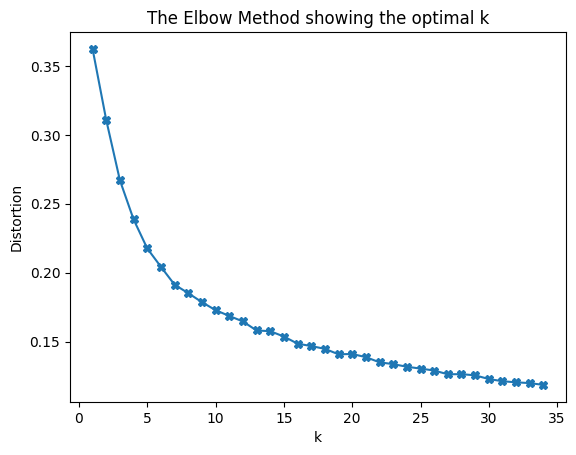

In [ ]:
distortions = []
K = range(1,35)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(z)
    kmeanModel.fit(z)
    distortions.append(sum(np.min(cdist(z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / z.shape[0])

# Plot the elbow
plt.plot(K, distortions, '-X')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on elbow-method, using 12 clusters seems optimal.

In [10]:
def fit_kmeans(z,word_list_z,num_clusters = 12):
    """ Fit kmeans on the embedding representations and return a mapping of word to cluster indices. Please use the default values for
        the rest of the kmeans parameters.

        Arg: z: word embeddings (ndarray)
              word_list_z: List of tokens in the model (List)
              num_clusters: Number of clusters (int)
        Returns:
            pre_trained_word2vec_model: word2vec model trained on the tokenized sentences.
            z2: word embeddings (ndarray)
            word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)

    """
    idx = KMeans(n_clusters = num_clusters).fit_predict(z)
    word_centroid_map_z = dict(zip(word_list_z, idx))
    ######################

    return word_centroid_map_z

In [11]:
word_centroid_map = fit_kmeans(z, word_list)

In [12]:
def print_clusters(word_centroid_map, model_name):
    """ Print max(20, cluster_size) words for each of the clusters.

        Args: word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)
              model_name: Model Name (str)


    """
    print("The clusters for {0} are....".format(model_name))
    clust=[]
    for i in range(12):
      clust.append([])
    for key, value in word_centroid_map.items():
      clust[value].append(key)

    for i in range(12):
      chr=[]
      for j in range(20):
        try:
          chr.append(clust[i][j])
        except IndexError:
          break
      print('cluster', i+1, ':', chr)
print_clusters(word_centroid_map, "fastText")

The clusters for fastText are....
cluster 1 : ['traffic', 'lane', 'road', 'tower', '40th', 'always', 'ave', 'e470', 'slow', 'backed', '470', 'east', 'avenue', 'interchange', 'chambers', 'west', 'intersection', 'exits', 'exiting', '64th']
cluster 2 : ['cars', 'along', 'going', 'much', 'getting', 'near', 'back', 'around', 'demand', 'entire', 'left', 'using', 'vehicles', 'turn', 'leaving', 'speeding', 'almost', 'problem', 'due', 'last']
cluster 3 : ['convenient', 'cell', 'phone', 'waiting', 'instead', 'close', 'thing', 'sure', 'others', 'evening', 'anywhere', 'departure', 'spent', 'rather', 'different', 'though', 'may', 'comes', 'greater', 'additionally']
cluster 4 : ['two', 'go', 'day', '10', 'add', 'say', 'avoid', 'opinion', '40', 'crashes', 'air', 'flying', 'cut', 'eb', 'aurora', '45', 'study', 'capacity', '00', 'needed']
cluster 5 : ['pena', '70', 'blvd', '56th', 'exit', '225', 'onto', 'merging', 'i70', 'green', 'ramp', 'valley', 'boulevard', 'south', 'ranch', 'rd', 'north', 'bound', 

In [13]:
def create_bag_of_centroids(comment, word_centroid_map, num_clusters = 12):

    count=np.zeros(num_clusters)
    for token in comment:
      try:
        count[word_centroid_map[token]]+=1
      except KeyError:
        continue

    return count

In [14]:
X_train_vect=[]
for comment in X_train:
    cr=clean_comments(comment, remove_stopwords = True)
    X_train_vect.append(create_bag_of_centroids(cr, word_centroid_map, 12))

X_train_vect=np.array(X_train_vect)

In [ ]:
X_train_vect

array([[ 0.,  0.,  1., ...,  3.,  2.,  3.],
       [ 0.,  4.,  2., ...,  3.,  0.,  2.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  2., 13., ...,  2.,  4.,  2.],
       [ 0.,  2.,  1., ...,  2.,  1.,  1.],
       [ 3., 10.,  0., ..., 12.,  8.,  3.]])

In [ ]:
X_train_vect.shape, y_train.shape

((601, 12), (601,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 5]}
clf = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=42), parameters, cv=10, verbose=2)
clf.fit(X=X_train_vect, y=y_train)
clf = clf.best_estimator_

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.0s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.0s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.0s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.0s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.05, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.05, so

In [ ]:
clf.fit(X_train_vect, y_train)

LogisticRegression(C=0.25, multi_class='multinomial', random_state=42,
                   solver='saga')

# **Testing out the test set now...**

In [15]:
from collections import defaultdict

test_map=defaultdict(list)
for i, comment in enumerate(X_test):
    cr=clean_comments(comment, remove_stopwords = True)
    vect_tup=tuple(create_bag_of_centroids(cr, word_centroid_map, 12))
    test_map[vect_tup].append(y_test.iloc[i])

X_test_vect=[]
for item in test_map:
  X_test_vect.append(list(item))

X_test_vect=np.array(X_test_vect)
X_test_vect

array([[ 0.,  2.,  0., ...,  3.,  0.,  3.],
       [ 0.,  5.,  4., ...,  5., 12., 14.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ...,
       [20., 17.,  3., ..., 13., 23., 16.],
       [ 0.,  0.,  0., ...,  1.,  3.,  2.],
       [ 8.,  0.,  1., ...,  5.,  4.,  4.]])

In [ ]:
y_test_pred=clf.predict_proba(X_test_vect)
y_test_pred

array([[8.06478725e-02, 7.93455819e-02, 5.46140895e-02, ...,
        5.07802026e-02, 2.74672127e-02, 7.16968236e-02],
       [2.53935905e-01, 1.08545076e-01, 1.08871552e-01, ...,
        1.24631007e-02, 1.11899131e-02, 7.66627067e-04],
       [9.78253592e-02, 7.11981439e-02, 6.78838917e-02, ...,
        4.55234178e-02, 5.39471207e-02, 4.06484321e-02],
       ...,
       [4.06401878e-01, 3.29804490e-01, 2.30272913e-02, ...,
        1.48674729e-03, 2.27823255e-05, 5.30137379e-03],
       [8.38353522e-02, 6.32220893e-02, 7.90998781e-02, ...,
        4.74706263e-02, 4.93055585e-02, 7.86438639e-02],
       [1.17017457e-01, 1.62377796e-01, 3.68460852e-02, ...,
        1.24606962e-02, 2.42439131e-03, 1.59856656e-01]])

In [ ]:
right=wrong=0
validTags=list(range(16))+[23]
for i, vect in enumerate(X_test_vect):
  probs=y_test_pred[i]
  tagList=test_map[tuple(vect)]
  problist=[[prob, tag] for prob, tag in zip(probs, validTags)]
  problist.sort(reverse=True)
  top_classes=[i[1] for i in problist][:3]
  for tag in tagList:
    if tag in top_classes:
      right+=1
    else:
      wrong+=1

right, wrong


(145, 152)

## 1.2. Approach 2: Using addition of vectors approach

In [16]:
def create_sentence_vector(comment, model):
  totvect=np.zeros(100)
  for token in comment:
    try:
      vect=model.wv[token]
    except KeyError:
      continue
    totvect+=vect

  return totvect

In [17]:
X_train.size

X_train_vect_1=[]
for comment in X_train:
    cr=clean_comments(comment, remove_stopwords = True)
    X_train_vect_1.append(create_sentence_vector(cr, model))

X_train_vect_1=np.array(X_train_vect_1)

In [ ]:
X_train_vect_1

array([[ -8.78892946,   1.87850587,  -1.22161909, ...,   1.77069437,
         -2.0353738 ,   4.19602038],
       [-16.29257766,   3.13585515,  -1.60882826, ...,   5.23561523,
         -3.67360132,   6.83020919],
       [ -6.93872029,   0.94431295,  -0.41151755, ...,   3.21521283,
         -1.57963462,   2.45869678],
       ...,
       [-23.31798461,   2.88865836,  -2.33303756, ...,   7.06915203,
         -5.13351018,  10.39347713],
       [ -6.81762656,   1.80664197,  -1.16748161, ...,   0.54647014,
         -1.49867674,   3.55985696],
       [-25.24572812,   6.66141362,  -4.30188905, ...,   2.76213196,
         -5.86597062,  12.61665962]])

In [ ]:
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 5]}
clf = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=42), parameters, cv=10, verbose=2)
clf.fit(X=X_train_vect_1, y=y_train)
clf_1 = clf.best_estimator_

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=0.05, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.05, so

In [ ]:
clf_1.fit(X_train_vect_1, y_train)

LogisticRegression(C=2, multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [ ]:
test_map_1=defaultdict(list)
for i, comment in enumerate(X_test):
    cr=clean_comments(comment, remove_stopwords = True)
    vect_tup=tuple(create_sentence_vector(cr, model))
    test_map_1[vect_tup].append(y_test.iloc[i])

X_test_vect_1=[]
for item in test_map_1:
  X_test_vect_1.append(list(item))

X_test_vect_1=np.array(X_test_vect_1)
X_test_vect_1

array([[ -5.71267726,   1.26018154,  -0.74445651, ...,   1.60265157,
         -1.26425437,   2.31652214],
       [-21.0673819 ,   6.93140862,  -4.42953189, ...,  -0.83779628,
         -4.83096071,  12.18973769],
       [ -1.41922665,   0.81132399,  -0.49016248, ...,  -0.65940276,
         -0.27312307,   0.93999805],
       ...,
       [-60.03010173,  13.15523643,  -7.50989939, ...,  15.7704234 ,
        -13.61597981,  26.17996124],
       [ -3.16166243,   1.00162555,  -0.68956961, ...,  -0.30682369,
         -0.62166848,   1.80422102],
       [-25.07922652,   3.66723891,  -2.68842531, ...,   8.94510548,
         -5.93547555,  10.33104317]])

In [ ]:
y_test_pred_1=clf_1.predict_proba(X_test_vect_1)
y_test_pred_1

array([[2.21929731e-01, 7.87100543e-02, 7.55795166e-02, ...,
        8.97519119e-03, 8.09775968e-03, 2.26814047e-01],
       [9.30495372e-02, 3.92936802e-02, 2.20482623e-01, ...,
        7.72067391e-03, 4.14387966e-02, 2.28906922e-04],
       [3.35770511e-01, 8.34070459e-02, 6.14800450e-02, ...,
        1.29472470e-02, 2.72140972e-02, 3.64162438e-02],
       ...,
       [3.42685146e-02, 4.19642432e-01, 3.85397307e-03, ...,
        4.59089158e-02, 5.67292552e-05, 1.12967178e-05],
       [2.23676736e-01, 8.33875915e-02, 6.83128063e-02, ...,
        5.29343432e-03, 1.05463501e-02, 2.81764227e-01],
       [8.64263615e-02, 1.68283256e-01, 8.26111754e-02, ...,
        8.59886529e-03, 5.26170678e-04, 1.05872826e-01]])

In [ ]:
right=[]
wrong=[]
validTags=list(range(16))+[23]
for i, vect in enumerate(X_test_vect_1):
  probs=y_test_pred_1[i]
  tagList=test_map_1[tuple(vect)]
  problist=[[prob, tag] for prob, tag in zip(probs, validTags)]
  problist.sort(reverse=True)
  top_classes=[i[1] for i in problist][:3]
  for tag in tagList:
    if tag in top_classes:
      right.append(tag)
    else:
      wrong.append(tag)

len(right), len(wrong)

(163, 134)

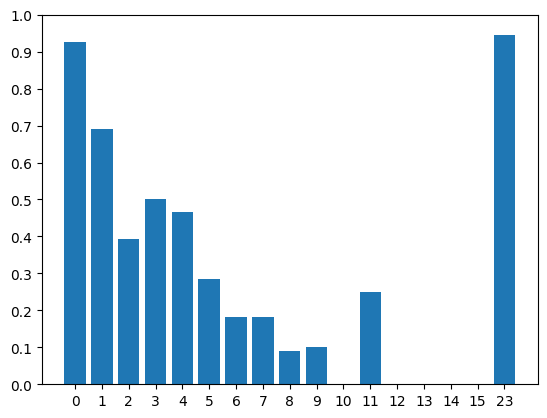

In [ ]:
from collections import Counter

right_counter=Counter(right)
wrong_counter=Counter(wrong)

correct_fract={i: [0, 0] for i in range(17)}

for tag in validTags:
  if tag in right_counter:
    correct_fract[validTags.index(tag)][0]+=right_counter[tag]
    correct_fract[validTags.index(tag)][1]+=right_counter[tag]
  if tag in wrong_counter:
    correct_fract[validTags.index(tag)][1]+=wrong_counter[tag]

for tag in correct_fract:
  correct_fract[tag]=(correct_fract[tag][0]/correct_fract[tag][1])


plt.bar(*zip(*correct_fract.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.show()


In [ ]:
for indx in correct_fract:
  print(validTags[indx], round(correct_fract[indx], 2))

0 0.93
1 0.69
2 0.39
3 0.5
4 0.47
5 0.29
6 0.18
7 0.18
8 0.09
9 0.1
10 0.0
11 0.25
12 0.0
13 0.0
14 0.0
15 0.0
23 0.94


We observe high amount of success with high frequency tags 0, 1 and 23. But the low frequency tags do not perform as well.

## 1.3. Approach 3: Using Google's T5 summarizer before vectorizing

In [ ]:
!pip install torch transformers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('T5-base')
model_t5=AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
X_train_vect_2=[]
n=0
for comment in X_train:
  n+=1
  print(f'{n}/601')
  original_len=len(comment.split())
  inputs=tokenizer.encode("sumarize: " + (comment),return_tensors='pt')
  output = model_t5.generate(inputs, min_length=0, max_length=max(original_len//2, 100))
  summary=tokenizer.decode(output[0], skip_special_tokens=True)
  cr=clean_comments(summary, remove_stopwords = True)
  X_train_vect_2.append(create_sentence_vector(cr, model))

1/601
2/601
3/601
4/601
5/601
6/601
7/601
8/601
9/601
10/601
11/601
12/601
13/601
14/601
15/601
16/601
17/601
18/601
19/601
20/601
21/601
22/601
23/601
24/601
25/601
26/601
27/601
28/601
29/601
30/601
31/601
32/601
33/601
34/601
35/601
36/601
37/601
38/601
39/601
40/601
41/601
42/601
43/601
44/601
45/601
46/601
47/601
48/601
49/601
50/601
51/601
52/601
53/601
54/601
55/601
56/601
57/601
58/601
59/601
60/601
61/601
62/601
63/601
64/601
65/601
66/601
67/601
68/601
69/601
70/601
71/601
72/601
73/601
74/601
75/601
76/601
77/601
78/601
79/601
80/601
81/601
82/601
83/601
84/601
85/601
86/601
87/601
88/601
89/601
90/601
91/601
92/601
93/601
94/601
95/601
96/601
97/601
98/601
99/601
100/601
101/601
102/601
103/601
104/601
105/601
106/601
107/601
108/601
109/601
110/601
111/601
112/601
113/601
114/601
115/601
116/601
117/601
118/601
119/601
120/601
121/601
122/601
123/601
124/601
125/601
126/601
127/601
128/601
129/601
130/601
131/601
132/601
133/601
134/601
135/601
136/601
137/601
138/601
139/

In [ ]:
X_train_vect_2=np.array(X_train_vect_2)

X_test_vect_2=[]
test_map_2=defaultdict(list)
for i, comment in enumerate(X_test):
  print(f'{i+1}/297')
  original_len=len(comment.split())
  inputs=tokenizer.encode("sumarize: " + (comment),return_tensors='pt')
  output = model_t5.generate(inputs, min_length=0, max_length=max(original_len//2, 100))
  summary=tokenizer.decode(output[0], skip_special_tokens=True)
  cr=clean_comments(summary, remove_stopwords = True)
  vect_tup=tuple(create_sentence_vector(cr, model))
  test_map_2[vect_tup].append(y_test.iloc[i])

X_test_vect_2=[]
for item in test_map_2:
  X_test_vect_2.append(list(item))

X_test_vect_2=np.array(X_test_vect_2)
X_test_vect_2

1/297
2/297
3/297
4/297
5/297
6/297
7/297
8/297
9/297
10/297
11/297
12/297
13/297
14/297
15/297
16/297
17/297
18/297
19/297
20/297
21/297
22/297
23/297
24/297
25/297
26/297
27/297
28/297
29/297
30/297
31/297
32/297
33/297
34/297
35/297
36/297
37/297
38/297
39/297
40/297
41/297
42/297
43/297
44/297
45/297
46/297
47/297
48/297
49/297
50/297
51/297
52/297
53/297
54/297
55/297
56/297
57/297
58/297
59/297
60/297
61/297
62/297
63/297
64/297
65/297
66/297
67/297
68/297
69/297
70/297
71/297
72/297
73/297
74/297
75/297
76/297
77/297
78/297
79/297
80/297
81/297
82/297
83/297
84/297
85/297
86/297
87/297
88/297
89/297
90/297
91/297
92/297
93/297
94/297
95/297
96/297
97/297
98/297
99/297
100/297
101/297
102/297
103/297
104/297
105/297
106/297
107/297
108/297
109/297
110/297
111/297
112/297
113/297
114/297
115/297
116/297
117/297
118/297
119/297
120/297
121/297
122/297
123/297
124/297
125/297
126/297
127/297
128/297
129/297
130/297
131/297
132/297
133/297
134/297
135/297
136/297
137/297
138/297
139/

array([[ -4.51350277,   1.05972564,  -0.10110204, ...,   1.51902703,
         -1.05865805,   1.51517076],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-11.36669243,   3.30945341,  -0.95793595, ...,   0.3116572 ,
         -2.82676341,   5.08527801],
       ...,
       [ -1.09856421,   0.23734725,  -0.04254475, ...,   0.13306957,
         -0.22003715,   0.51144834],
       [ -9.85118553,   2.57867295,  -0.29449067, ...,   2.54780626,
         -2.33850896,   3.53582135],
       [-10.46809393,   2.14384811,  -0.23636566, ...,   3.87850158,
         -2.56436406,   3.75952983]])

In [ ]:
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'C': [0.05, 0.1, 0.25, 0.5, 1, 2, 5]}
clf = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=42), parameters, cv=10, verbose=2)
clf.fit(X=X_train_vect_2, y=y_train)
clf_2 = clf.best_estimator_
clf_2.fit(X_train_vect_2, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.3s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.4s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.2s
[CV] END ...............................C=0.05, solver=lbfgs; total time=   0.1s
[CV] END ...........................C=0.05, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.05, so

LogisticRegression(C=0.1, multi_class='multinomial', random_state=42,
                   solver='saga')

In [ ]:
y_test_pred_2=clf_2.predict_proba(X_test_vect_2)
y_test_pred_2

array([[1.72303526e-01, 1.42360118e-01, 6.45612481e-02, ...,
        6.56101407e-03, 3.15036535e-03, 1.99862240e-01],
       [1.64614454e-01, 7.62020531e-02, 6.52533037e-02, ...,
        3.15422392e-02, 3.49368747e-02, 1.62627619e-01],
       [1.42078541e-01, 1.14864476e-01, 1.64087696e-01, ...,
        7.56152842e-03, 4.99876443e-04, 9.01652480e-02],
       ...,
       [1.82750016e-01, 7.04254008e-02, 5.57715527e-02, ...,
        2.35151454e-02, 2.13405690e-02, 1.92167283e-01],
       [1.32475532e-01, 2.39078902e-01, 8.56442020e-02, ...,
        1.75137961e-03, 2.53939351e-04, 1.46052488e-01],
       [1.50754833e-01, 1.76872437e-01, 3.11011779e-02, ...,
        4.70125712e-04, 8.65738671e-05, 2.72987168e-01]])

In [ ]:
right=[]
wrong=[]
validTags=list(range(16))+[23]
for i, vect in enumerate(X_test_vect_2):
  probs=y_test_pred_2[i]
  tagList=test_map_2[tuple(vect)]
  problist=[[prob, tag] for prob, tag in zip(probs, validTags)]
  problist.sort(reverse=True)
  top_classes=[i[1] for i in problist][:3]
  for tag in tagList:
    if tag in top_classes:
      right.append(tag)
    else:
      wrong.append(tag)

len(right), len(wrong)

(138, 159)

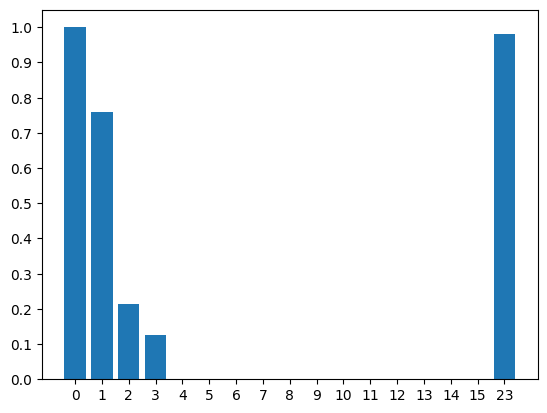

In [ ]:
right_counter=Counter(right)
wrong_counter=Counter(wrong)

correct_fract={i: [0, 0] for i in range(17)}

for tag in validTags:
  if tag in right_counter:
    correct_fract[validTags.index(tag)][0]+=right_counter[tag]
    correct_fract[validTags.index(tag)][1]+=right_counter[tag]
  if tag in wrong_counter:
    correct_fract[validTags.index(tag)][1]+=wrong_counter[tag]

for tag in correct_fract:
  correct_fract[tag]=(correct_fract[tag][0]/correct_fract[tag][1])


plt.bar(*zip(*correct_fract.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.show()

In [ ]:
for indx in correct_fract:
  print(validTags[indx], round(correct_fract[indx], 2))

0 1.0
1 0.76
2 0.21
3 0.12
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
23 0.98


In [ ]:
np.savetxt("Train_T5_vector.csv", X_train_vect_2, delimiter=',')
np.savetxt("Test_T5_vector.csv", X_test_vect_2, delimiter=',')

This approach does better for the higher frequency classes again. So, we revert back to the previous approach without the T5 summaries.

## 1.4. Setting up baselines

In [ ]:
train_vect_map=defaultdict(list)
comment_average={}
comment_count=defaultdict(float)

for i, vect in enumerate(X_train_vect_1):
  tag=y_train.iloc[i]
  train_vect_map[tuple(vect)].append(tag)
  if tag not in comment_average:
    comment_average[tag]=np.zeros(100)
  comment_average[tag]+=vect
  comment_count[tag]+=1.0

for tag in comment_average:
  comment_average[tag]/=comment_count[tag]

df = pd.read_excel('TaggedData.xlsx', sheet_name='tagInfo')
tag_vector={}
for index, row in df.iterrows():
  tag_vector[int(row['Index'])]=create_sentence_vector(clean_comments(row['Tag']), model)

X_train_vect_filtered=[]
y_train_list=[]
for item in train_vect_map:
  X_train_vect_filtered.append(list(item))
  y_train_list.append(train_vect_map[item])

X_train_vect_filtered=np.array(X_train_vect_filtered)

In [ ]:
from numpy import dot
from numpy.linalg import norm

def getCosineSimilarList(vect, lookup):
  cosineList=[]
  for tag in lookup:
    cosineList.append([dot(lookup[tag], vect)/(norm(lookup[tag])*norm(vect)), tag])
  cosineList.sort(reverse=True)
  return [i[1] for i in cosineList[:3]]

test_vect_map=defaultdict(list)
right1=[]
wrong1=[]
right2=[]
wrong2=[]
for i, vect in enumerate(X_test_vect_1):
  tag=y_test.iloc[i]
  test_vect_map[tuple(vect)].append(tag)
  tagList=getCosineSimilarList(vect, tag_vector)
  if tag in tagList:
    right1.append(tag)
  else:
    wrong1.append(tag)

  tagList=getCosineSimilarList(vect, comment_average)
  if tag in tagList:
    right2.append(tag)
  else:
    wrong2.append(tag)

X_test_vect_filtered=[]
y_test_list=[]
for item in test_vect_map:
  X_test_vect_filtered.append(list(item))
  y_test_list.append(test_vect_map[item])

X_test_vect_filtered=np.array(X_test_vect_filtered)


**Baseline 1: Using cosine similarity between Tag text and the comment**



0 0.08
1 0.0
2 0.0
3 0.0
4 0.0
5 0.17
6 0.0
7 0.1
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
23 0.02


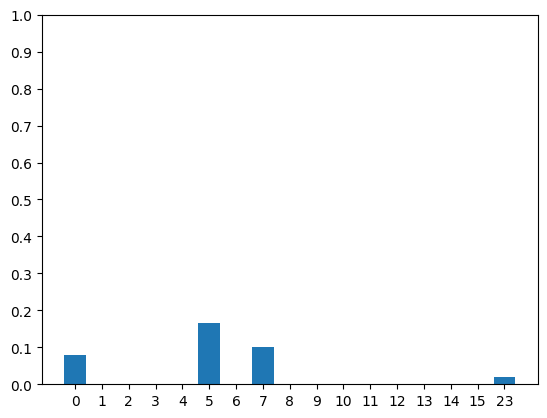

In [ ]:
right_counter=Counter(right1)
wrong_counter=Counter(wrong1)

correct_fract={i: [0, 0] for i in range(17)}

for tag in validTags:
  if tag in right_counter:
    correct_fract[validTags.index(tag)][0]+=right_counter[tag]
    correct_fract[validTags.index(tag)][1]+=right_counter[tag]
  if tag in wrong_counter:
    correct_fract[validTags.index(tag)][1]+=wrong_counter[tag]

for tag in correct_fract:
  correct_fract[tag]=(correct_fract[tag][0]/correct_fract[tag][1])

for indx in correct_fract:
  print(validTags[indx], round(correct_fract[indx], 2))

plt.bar(*zip(*correct_fract.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.show()

**Baseline 2: Using cosine similarity between Tag comment average vector and the comment**

0 0.02
1 0.14
2 0.19
3 0.0
4 0.27
5 0.42
6 0.36
7 0.0
8 0.22
9 0.0
10 0.0
11 0.0
12 0.17
13 0.0
14 0.0
15 0.0
23 0.53


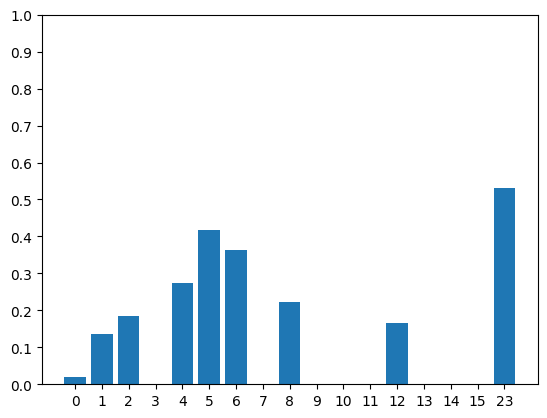

In [ ]:
right_counter=Counter(right2)
wrong_counter=Counter(wrong2)

correct_fract={i: [0, 0] for i in range(17)}

for tag in validTags:
  if tag in right_counter:
    correct_fract[validTags.index(tag)][0]+=right_counter[tag]
    correct_fract[validTags.index(tag)][1]+=right_counter[tag]
  if tag in wrong_counter:
    correct_fract[validTags.index(tag)][1]+=wrong_counter[tag]

for tag in correct_fract:
  correct_fract[tag]=(correct_fract[tag][0]/correct_fract[tag][1])

for indx in correct_fract:
  print(validTags[indx], round(correct_fract[indx], 2))

plt.bar(*zip(*correct_fract.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.show()

## 1.5. Using Individual binary classifier for each tag

### 1.5.1. Naive Bayes Classifier

In [ ]:
NB_accuracy={}
NB_recall={}

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score

for tag in validTags:
  y_train_tag=[int(tag in item) for item in y_train_list]
  y_test_true=[int(tag in item) for item in y_test_list]
  clf = GaussianNB()
  clf.fit(X_train_vect_filtered, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_filtered)
  NB_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  NB_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(NB_accuracy)
print(NB_recall)

{0: 0.298, 1: 0.57, 2: 0.819, 3: 0.653, 4: 0.234, 5: 0.853, 6: 0.547, 7: 0.834, 8: 0.879, 9: 0.396, 10: 0.581, 11: 0.853, 12: 0.215, 13: 0.415, 14: 0.898, 15: 0.385, 23: 0.34}
{0: 0.9, 1: 0.318, 2: 0.185, 3: 0.25, 4: 0.909, 5: 0.167, 6: 0.182, 7: 0.1, 8: 0.111, 9: 0.625, 10: 0.333, 11: 0.286, 12: 0.833, 13: 0.75, 14: 0.0, 15: 0.0, 23: 0.776}


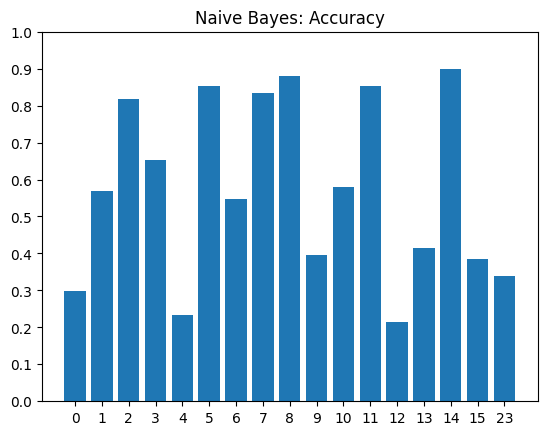

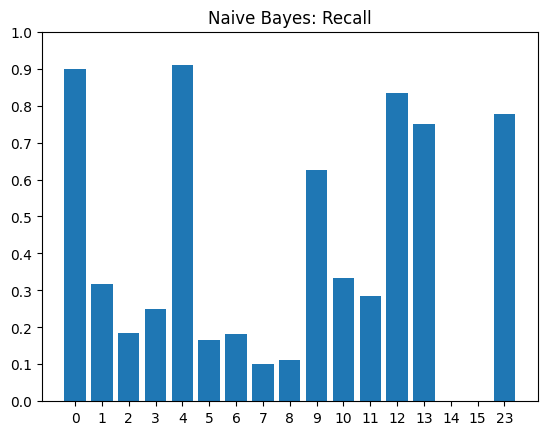

In [ ]:
order_val=NB_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=NB_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes: Recall')
plt.show()

### 1.5.2. XG Boost

In [ ]:
import xgboost as xgb

parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [0.001, 0.01, 0.1, 0.5]}
XG_accuracy={}
XG_recall={}

for tag in validTags:
  print(f'\nTraining for Tag {tag}')
  y_train_tag=[int(tag in item) for item in y_train_list]
  y_test_true=[int(tag in item) for item in y_test_list]
  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=10)
  clf.fit(X_train_vect_filtered, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_filtered, y_train_tag)
  y_test_pred=clf.predict_proba(X_test_vect_filtered)
  XG_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  XG_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(XG_accuracy)
print(XG_recall)


Training for Tag 0

Training for Tag 1

Training for Tag 2

Training for Tag 3

Training for Tag 4

Training for Tag 5

Training for Tag 6

Training for Tag 7

Training for Tag 8

Training for Tag 9

Training for Tag 10

Training for Tag 11

Training for Tag 12

Training for Tag 13

Training for Tag 14

Training for Tag 15

Training for Tag 23
{0: 0.766, 1: 0.913, 2: 0.898, 3: 0.906, 4: 0.958, 5: 0.955, 6: 0.958, 7: 0.962, 8: 0.932, 9: 0.97, 10: 0.966, 11: 0.974, 12: 0.977, 13: 0.985, 14: 0.985, 15: 0.992, 23: 0.766}
{0: 0.04, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 23: 0.184}


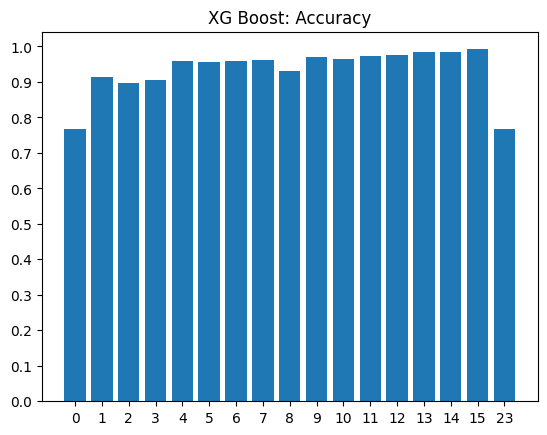

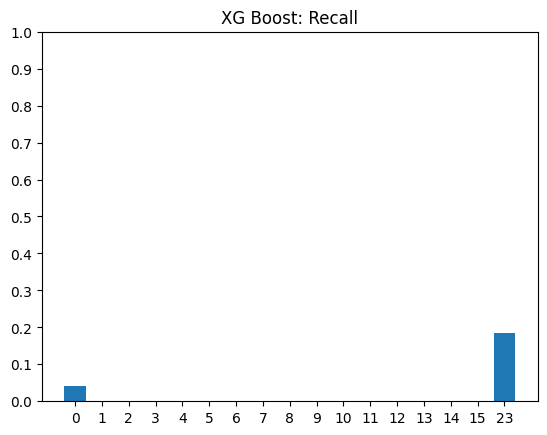

In [ ]:
order_val=XG_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=XG_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost: Recall')
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.0001, 0.01, 1]}

MLP_accuracy={}
MLP_recall={}

for tag in validTags:
  print(f'\nTraining for Tag {tag}')
  y_train_tag=[int(tag in item) for item in y_train_list]
  y_test_true=[int(tag in item) for item in y_test_list]
  clf = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42, learning_rate='adaptive', solver='lbfgs', warm_start=True), parameters, cv=5)
  clf.fit(X_train_vect_filtered, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_filtered, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_filtered)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  MLP_recall[tag]=recall
  MLP_accuracy[tag]=accuracy

print(MLP_accuracy)
print(MLP_recall)


Training for Tag 0
0.1 0.755

Training for Tag 1
0.0 0.898

Training for Tag 2
0.037 0.868

Training for Tag 3
0.083 0.894

Training for Tag 4
0.0 0.958

Training for Tag 5
0.0 0.951

Training for Tag 6
0.0 0.955

Training for Tag 7
0.1 0.947

Training for Tag 8
0.0 0.958

Training for Tag 9
0.0 0.97

Training for Tag 10
0.0 0.962

Training for Tag 11
0.143 0.955

Training for Tag 12
0.0 0.977

Training for Tag 13
0.0 0.985

Training for Tag 14
0.0 0.981

Training for Tag 15
0.0 0.992

Training for Tag 23
0.327 0.743
{0: 0.755, 1: 0.898, 2: 0.868, 3: 0.894, 4: 0.958, 5: 0.951, 6: 0.955, 7: 0.947, 8: 0.958, 9: 0.97, 10: 0.962, 11: 0.955, 12: 0.977, 13: 0.985, 14: 0.981, 15: 0.992, 23: 0.743}
{0: 0.1, 1: 0.0, 2: 0.037, 3: 0.083, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.1, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.143, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 23: 0.327}


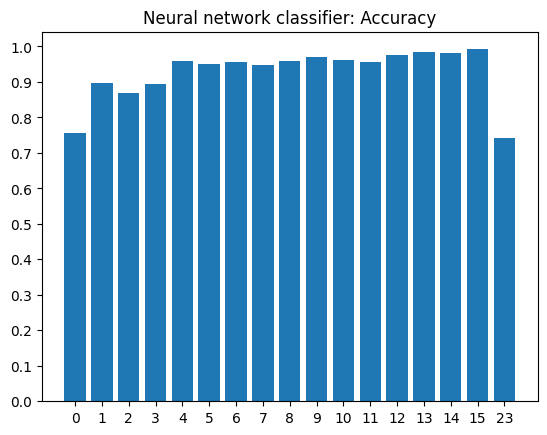

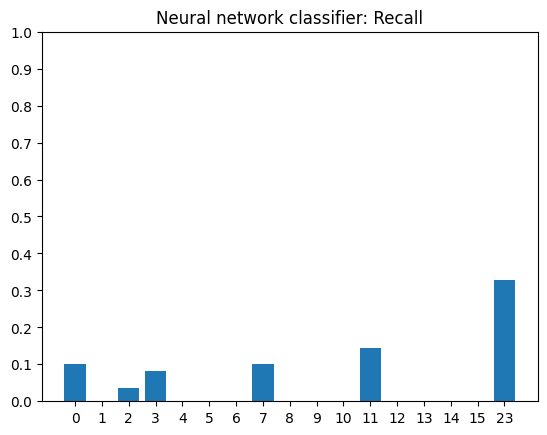

In [ ]:
order_val=MLP_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Neural network classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=MLP_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Neural network classifier: Recall')
plt.show()

### 1.5.4. Naive Bayes Revisited: Bag of centroids

In [19]:
from collections import defaultdict
boc_train_map=defaultdict(list)

for i, comment in enumerate(X_train):
    cr=clean_comments(comment, remove_stopwords = True)
    vect=create_bag_of_centroids(cr, word_centroid_map, 12)
    boc_train_map[tuple(vect)].append(y_train.iloc[i])

y_train_list_boc=[]
X_train_vect_boc=[]
for item in boc_train_map:
  X_train_vect_boc.append(list(item))
  y_train_list_boc.append(boc_train_map[item])

X_train_vect_boc=np.array(X_train_vect_boc)

boc_test_map=defaultdict(list)

for i, comment in enumerate(X_test):
    cr=clean_comments(comment, remove_stopwords = True)
    vect=create_bag_of_centroids(cr, word_centroid_map, 12)
    boc_test_map[tuple(vect)].append(y_test.iloc[i])

y_test_list_boc=[]
X_test_vect_boc=[]
for item in boc_test_map:
  X_test_vect_boc.append(list(item))
  y_test_list_boc.append(boc_test_map[item])

X_test_vect_boc=np.array(X_test_vect_boc)

In [ ]:
NB_accuracy={}
NB_recall={}

for tag in validTags:
  y_train_tag=[int(tag in item) for item in y_train_list_boc]
  y_test_true=[int(tag in item) for item in y_test_list_boc]
  clf = GaussianNB()
  clf.fit(X_train_vect_boc, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_boc)
  NB_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  NB_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(NB_accuracy)
print(NB_recall)

{0: 0.274, 1: 0.852, 2: 0.802, 3: 0.875, 4: 0.27, 5: 0.863, 6: 0.133, 7: 0.114, 8: 0.894, 9: 0.133, 10: 0.913, 11: 0.76, 12: 0.247, 13: 0.365, 14: 0.863, 15: 0.532, 23: 0.475}
{0: 0.907, 1: 0.138, 2: 0.107, 3: 0.042, 4: 0.8, 5: 0.143, 6: 0.727, 7: 1.0, 8: 0.0, 9: 1.0, 10: 0.0, 11: 0.375, 12: 1.0, 13: 0.75, 14: 0.25, 15: 0.75, 23: 0.812}


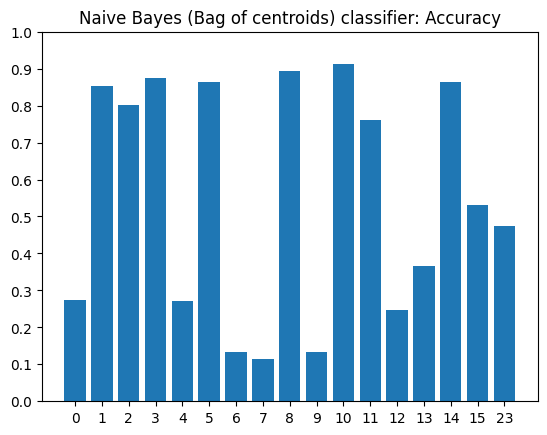

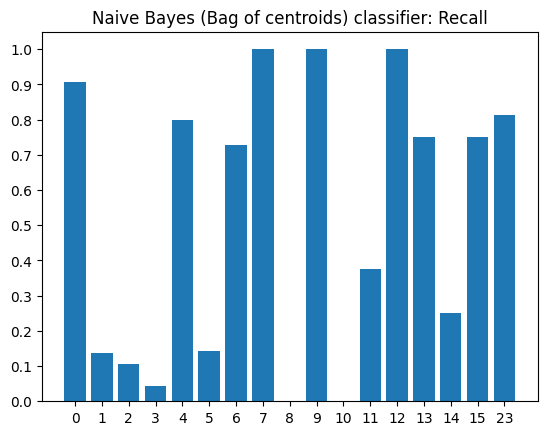

In [ ]:
order_val=NB_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Bag of centroids) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=NB_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Bag of centroids) classifier: Recall')
plt.show()

### 1.5.5. k Nearest Neighbors: Bag of centroids

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

pca = PCA(5)
X_train_vect_boc_pca = pca.fit_transform(X_train_vect_boc)
X_test_vect_boc_pca = pca.transform(X_test_vect_boc)

parameters = {'n_neighbors': [2, 5, 10, 20, 30], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30, 50], 'p': [1, 2]}

KNN_accuracy={}
KNN_recall={}

for tag in validTags:
  print(f'\nkNN Training for Tag {tag}')
  y_train_tag=[int(tag in item) for item in y_train_list_boc]
  y_test_true=[int(tag in item) for item in y_test_list_boc]
  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
  clf.fit(X_train_vect_boc_pca, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc_pca, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_boc_pca)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  KNN_recall[tag]=recall
  KNN_accuracy[tag]=accuracy

print(KNN_accuracy)
print(KNN_recall)


kNN Training for Tag 0
0.037 0.798

kNN Training for Tag 1
0.0 0.89

kNN Training for Tag 2
0.0 0.894

kNN Training for Tag 3
0.0 0.909

kNN Training for Tag 4
0.0 0.943

kNN Training for Tag 5
0.0 0.947

kNN Training for Tag 6
0.0 0.951

kNN Training for Tag 7
0.0 0.958

kNN Training for Tag 8
0.0 0.958

kNN Training for Tag 9
0.0 0.962

kNN Training for Tag 10
0.0 0.966

kNN Training for Tag 11
0.0 0.966

kNN Training for Tag 12
0.0 0.973

kNN Training for Tag 13
0.0 0.985

kNN Training for Tag 14
0.0 0.985

kNN Training for Tag 15
0.0 0.985

kNN Training for Tag 23
0.396 0.852
{0: 0.798, 1: 0.89, 2: 0.894, 3: 0.909, 4: 0.943, 5: 0.947, 6: 0.951, 7: 0.958, 8: 0.958, 9: 0.962, 10: 0.966, 11: 0.966, 12: 0.973, 13: 0.985, 14: 0.985, 15: 0.985, 23: 0.852}
{0: 0.037, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 23: 0.396}


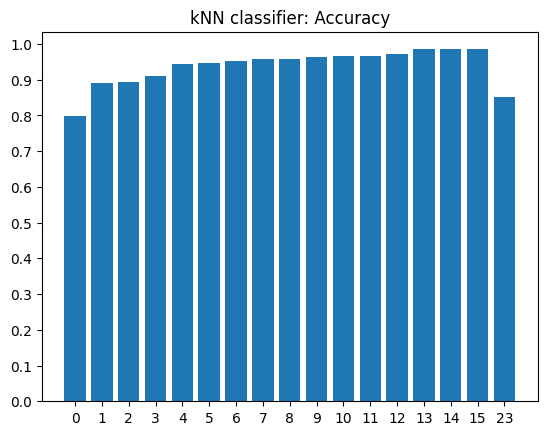

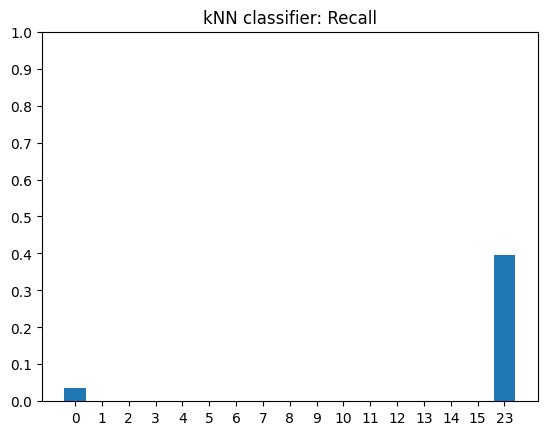

In [ ]:
order_val=KNN_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('kNN classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=KNN_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('kNN classifier: Recall')
plt.show()

In [ ]:
import xgboost as xgb

parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [ 0.01, 0.05, 0.1, 0.5]}
XG_accuracy={}
XG_recall={}

for tag in validTags:
  print(f'\nTraining for Tag {tag}')
  y_train_tag=[int(tag in item) for item in y_train_list_boc]
  y_test_true=[int(tag in item) for item in y_test_list_boc]
  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=5)
  clf.fit(X_train_vect_boc, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_boc)
  XG_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  XG_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(XG_accuracy)
print(XG_recall)


Training for Tag 0

Training for Tag 1

Training for Tag 2

Training for Tag 3

Training for Tag 4

Training for Tag 5

Training for Tag 6

Training for Tag 7

Training for Tag 8

Training for Tag 9

Training for Tag 10

Training for Tag 11

Training for Tag 12

Training for Tag 13

Training for Tag 14

Training for Tag 15

Training for Tag 23
{0: 0.795, 1: 0.89, 2: 0.875, 3: 0.909, 4: 0.943, 5: 0.947, 6: 0.958, 7: 0.958, 8: 0.958, 9: 0.962, 10: 0.939, 11: 0.97, 12: 0.973, 13: 0.985, 14: 0.985, 15: 0.985, 23: 0.859}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 23: 0.375}


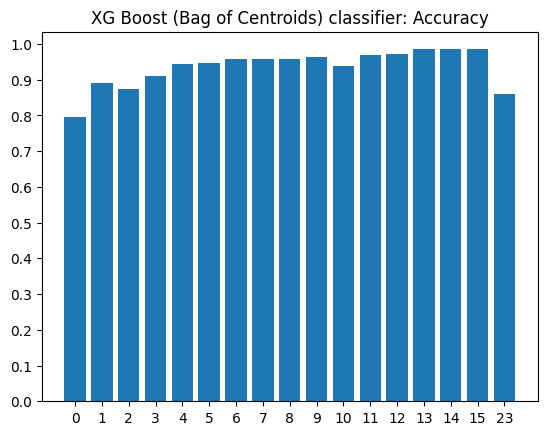

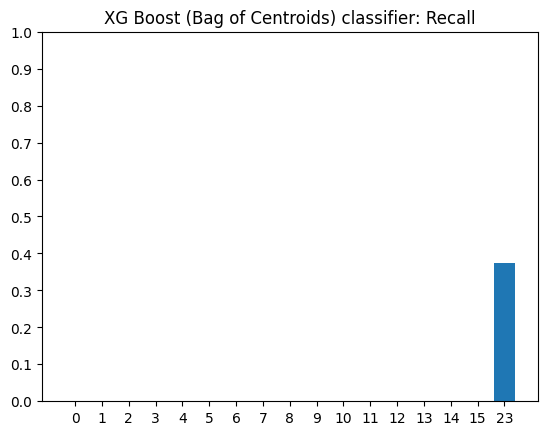

In [ ]:
order_val=XG_accuracy.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Bag of Centroids) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=XG_recall.copy()
val=order_val[23]
order_val[16]=val
del order_val[23]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(17), validTags)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Bag of Centroids) classifier: Recall')
plt.show()

## 1.6. Trying on focus on lesser informative tags and training more informative tag beyond that

Index	Tag

0	A-Line: more reliable, higher frequency, faster or express A-Line service to DEN

1	Transit: direct transit services from metro Denver cities/suburbs to DEN

2	Transit: Cheaper A-Line and/or bus fares to DEN

3	Transit: More reliable and/or higher frequency transit service

4	Transit: Better connections to A-Line and/or between RTD services

5	Bike Infrastructure: Better bike facilities and/or bike connections to transit

6	Transit: Safer and/or cleaner transit vehicles and/or stations

7	Transit: More off-peak transit service

8	Park & ride: Cheaper or more convenient park & ride facilities with ample parkings and services to DEN

9	Transit: more convenient / easier access to transit

10	Transit: Dedicated bus lanes, better bus services or bus rapid transit (BRT)

11	Park & ride: safer and/or more secure park & ride facilities and/or covered parking

12	Transit: Already use and/or supports the use of sustainable transport modes

13	A-Line: Additional stops and/or add 72nd and Himalaya Station

14	A-Line: double tracking to reduce delays and increase frequency

15	Bike Infrastructure: Secure bike storage at RTD stations



Tags 0, 13, 14 talk about A-line connection.

Tags 1-4, 6, 7, 9, 10, 12 all talk about transits one way or another.

Tags 5, 8, 11, 15 talk about bikes/peds or "park and ride".

Tag 23 does not talk about any of that


We can seperate them out and then performa classification seperately.



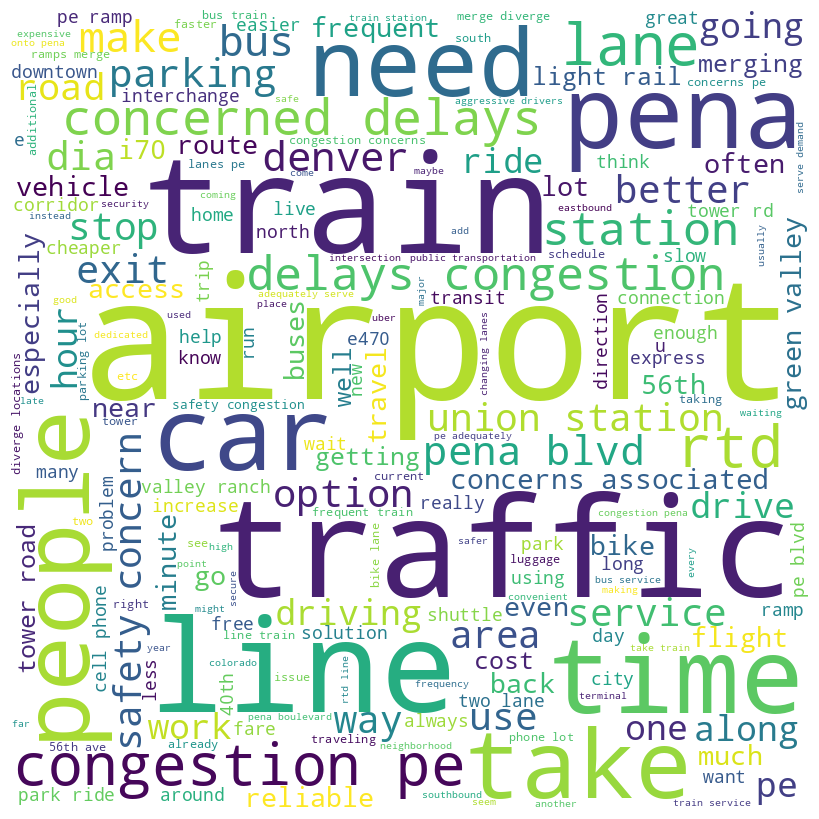

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)


wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(' '.join([' '.join(item) for item in sentences]))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

a_line={0, 13, 14}
transit={1, 2, 3, 4, 7, 9, 10, 12}
bike_park_ride={5, 8, 11, 15}
nothing={23}


def classifyTags(tagList):
  res=[0, 0, 0, 0]
  for tag in tagList:
    res[0]+=int(tag in a_line)
    res[1]+=int(tag in transit)
    res[2]+=int(tag in bike_park_ride)
    res[3]+=int(tag in nothing)

  Res=[]
  for i, count in enumerate(res):
    if count>0:
      Res.append(i)

  return Res


NB_accuracy={}
NB_recall={}
NB_models={}

for tag in range(4):
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  clf = GaussianNB()
  clf.fit(X_train_vect_boc, y_train_tag)
  NB_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  NB_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  NB_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(NB_accuracy)
print(NB_recall)

parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [ 0.01, 0.05, 0.1, 0.5]}
XG_accuracy={}
XG_recall={}
XG_models={}

for tag in range(4):
  print(f'\nXGBoost Training for Tag {tag}')
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=5)
  clf.fit(X_train_vect_boc, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc, y_train_tag)
  XG_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  XG_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  XG_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(XG_accuracy)
print(XG_recall)


NameError: name 'y_train_list_boc' is not defined

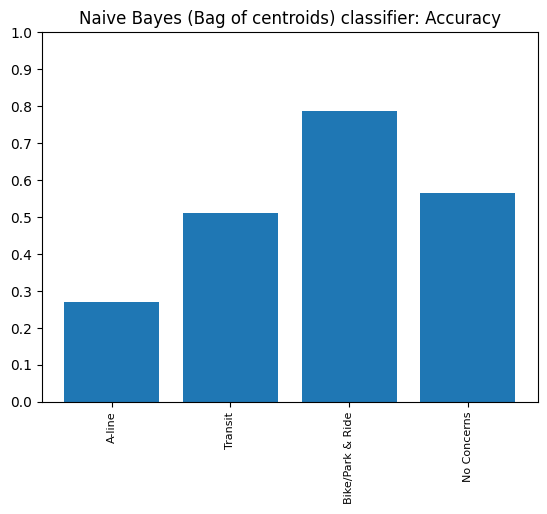

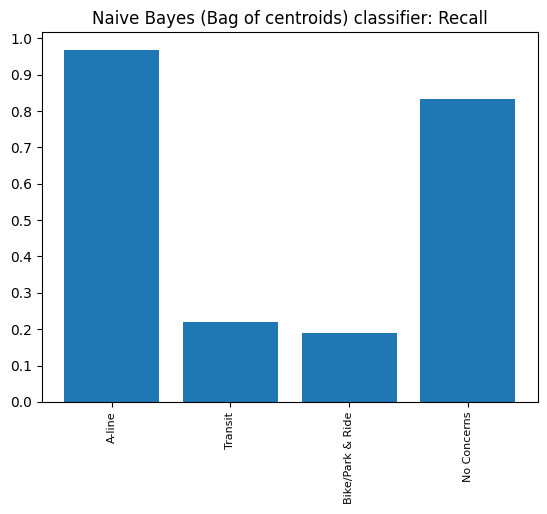

In [ ]:
order_val=NB_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Bag of centroids) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=NB_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Bag of centroids) classifier: Recall')
plt.show()

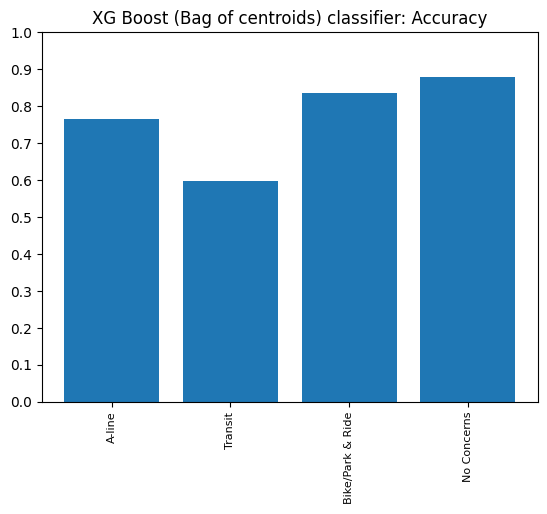

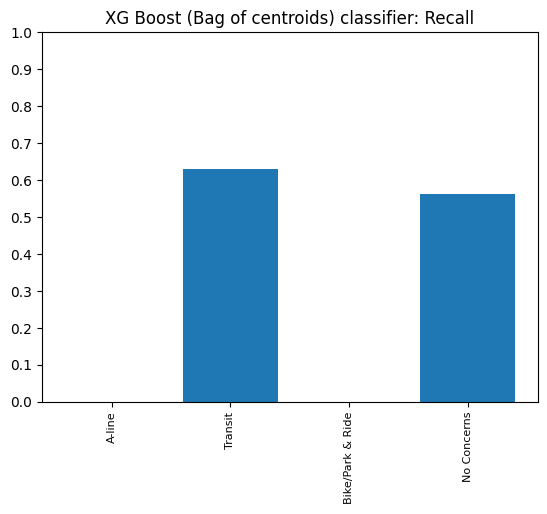

In [ ]:
order_val=XG_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Bag of centroids) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=XG_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Bag of centroids) classifier: Recall')
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.01, 0.1, 1]}

MLP_accuracy={}
MLP_recall={}

for tag in range(4):
  print(f'\nNeural network Training for Tag {tag}')
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  clf = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42, learning_rate='adaptive', solver='lbfgs', warm_start=True), parameters, cv=5)
  clf.fit(X_train_vect_boc, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc, y_train_tag)
  y_test_pred=clf.predict(X_test_vect_boc)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  MLP_recall[tag]=recall
  MLP_accuracy[tag]=accuracy

print(MLP_accuracy)
print(MLP_recall)


Neural network Training for Tag 0
0.065 0.739

Neural network Training for Tag 1
0.512 0.598

Neural network Training for Tag 2
0.0 0.848

Neural network Training for Tag 3
0.625 0.86
{0: 0.739, 1: 0.598, 2: 0.848, 3: 0.86}
{0: 0.065, 1: 0.512, 2: 0.0, 3: 0.625}


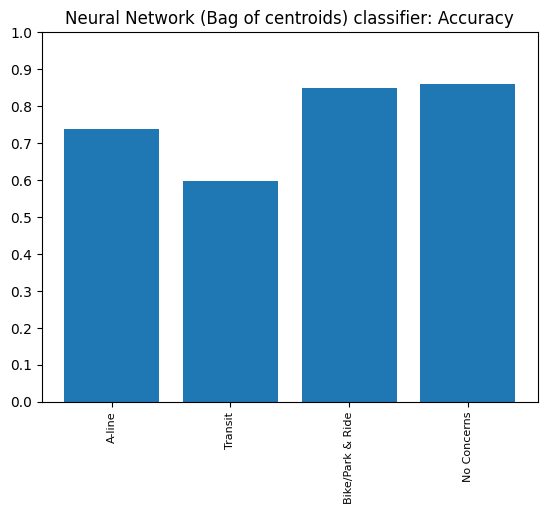

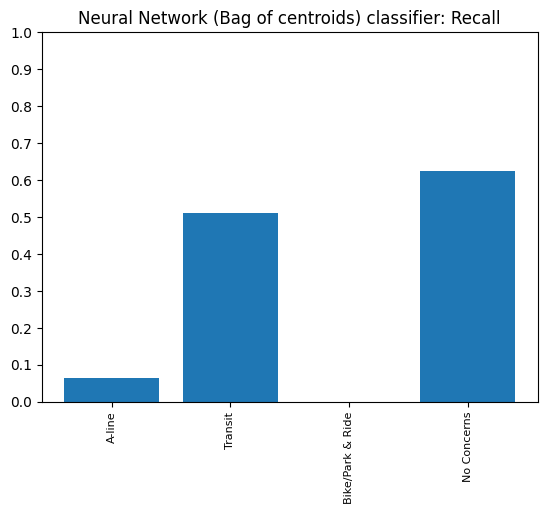

In [ ]:
order_val=MLP_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Neural Network (Bag of centroids) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=MLP_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=8)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Neural Network (Bag of centroids) classifier: Recall')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

pca = PCA(4)
X_train_vect_boc_pca = pca.fit_transform(X_train_vect_boc)
X_test_vect_boc_pca = pca.transform(X_test_vect_boc)

parameters = {'n_neighbors': [2, 5, 10, 20, 30], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30, 50], 'p': [1, 2]}

KNN_accuracy={}
KNN_recall={}
KNN_models={}

for tag in range(4):
  print(f'\nKNN Training for Tag {tag}')
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
  clf.fit(X_train_vect_boc_pca, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc_pca, y_train_tag)
  KNN_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc_pca)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  KNN_recall[tag]=recall
  KNN_accuracy[tag]=accuracy


print(KNN_accuracy)
print(KNN_recall)


KNN Training for Tag 0
0.065 0.773

KNN Training for Tag 1
0.323 0.553

KNN Training for Tag 2
0.0 0.86

KNN Training for Tag 3
0.292 0.841
{0: 0.773, 1: 0.553, 2: 0.86, 3: 0.841}
{0: 0.065, 1: 0.323, 2: 0.0, 3: 0.292}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': [10, 50, 100, 200, 250], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}

RF_accuracy={}
RF_recall={}
RF_models={}

for tag in range(4):
  print(f'\nRandom Forest Training for Tag {tag}')
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=5)
  clf.fit(X_train_vect_boc, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_vect_boc, y_train_tag)
  RF_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  RF_recall[tag]=recall
  RF_accuracy[tag]=accuracy

print(RF_accuracy)
print(RF_recall)


Rnadom Forest Training for Tag 0
0.145 0.67

Rnadom Forest Training for Tag 1
0.606 0.598

Rnadom Forest Training for Tag 2
0.081 0.803

Rnadom Forest Training for Tag 3
0.583 0.886
{0: 0.67, 1: 0.598, 2: 0.803, 3: 0.886}
{0: 0.145, 1: 0.606, 2: 0.081, 3: 0.583}


In [ ]:
best_models={'a-line': NB_models[0], 'transit': XG_models[1], 'bike/park/ride': NB_models[2], 'other': NB_models[3]}

### 1.6.1. Focusing on Transit

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

transit={1, 2, 3, 4, 7, 9, 10, 12}

accuracy={}
recall={}
X_train_transit=[]
y_train_transit_list=[]
for i, vect in enumerate(X_train_vect_boc):
  chosen=[]
  tags=y_train_list_boc[i]
  for tag in tags:
    if tag in transit:
      chosen.append(tag)
  if chosen:
    X_train_transit.append(vect)
    y_train_transit_list.append(chosen)

y_pred_transit=best_models['transit'].predict(X_test_vect_boc)


def isTransit(tags):
  filterlist=[]
  for tag in tags:
    if tag in transit:
      filterlist.append(tag)
  return filterlist

X_test_transit=[]
y_test_transit_true=[]
y_test_nottransit_true=[]
for i, vect in enumerate(X_test_vect_boc):
  if y_pred_transit[i]==1:
    X_test_transit.append(vect)
    y_test_transit_true.append(isTransit(y_test_list_boc[i]))
  else:
    y_test_nottransit_true.append(0 if isTransit(y_test_list_boc[i])!=[] else 1)

recall[24]=round(recall_score(y_test_nottransit_true, [1]*len(y_test_nottransit_true)), 3)
accuracy[24]=round(accuracy_score(y_test_nottransit_true, [1]*len(y_test_nottransit_true)), 3)

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  clf = GaussianNB()
  clf.fit(X_train_transit, y_train_tag)
  y_test_pred=clf.predict(X_test_transit)
  recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(accuracy)
print(recall)

{24: 0.568, 1: 0.669, 2: 0.752, 3: 0.621, 4: 0.455, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}
{24: 1.0, 1: 0.222, 2: 0.056, 3: 0.278, 4: 0.8, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333}


#### 1.6.1.1.  Focusing on Transit: Naive Bayes

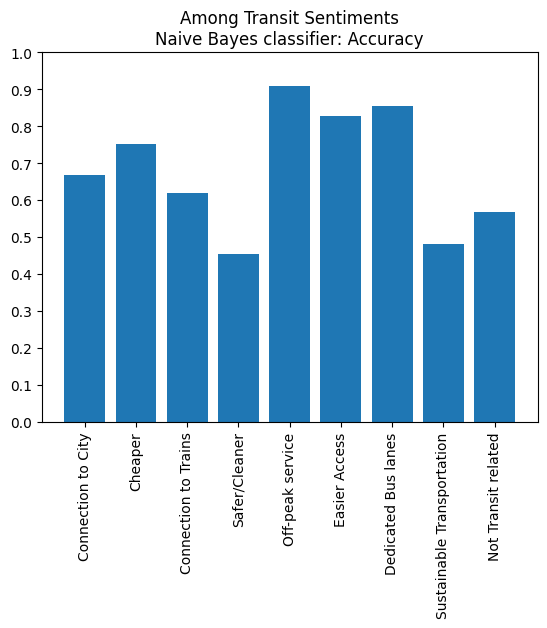

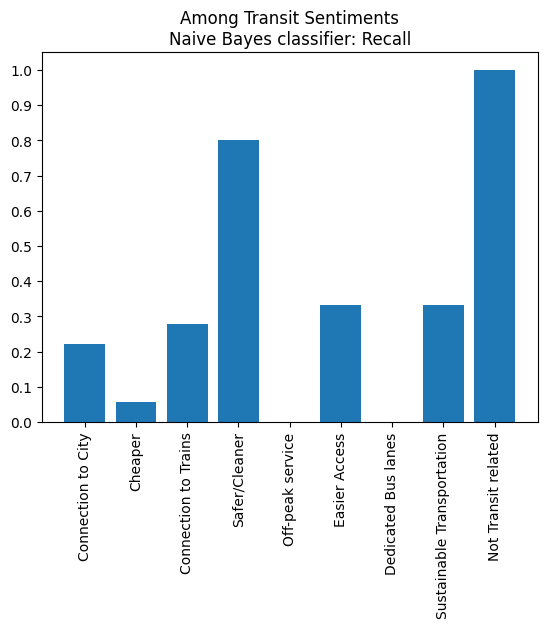

In [ ]:
accuracy={24: 0.568, 1: 0.669, 2: 0.752, 3: 0.621, 4: 0.455, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}
recall={24: 1.0, 1: 0.222, 2: 0.056, 3: 0.278, 4: 0.8, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333}

list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in accuracy:
  order_val[list2d.index(item)]=accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNaive Bayes classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in recall:
  order_val[list2d.index(item)]=recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNaive Bayes classifier: Recall')
plt.show()
plt.clf()
plt.close()


In [ ]:
parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [ 0.01, 0.05, 0.1, 0.5]}

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  print(f'\nXGBoost training for Tag {tag}')
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=5)
  clf.fit(X_train_transit, y_train_tag)
  clf = clf.best_estimator_
  clf.fit(X_train_transit, y_train_tag)
  y_test_pred=clf.predict(X_test_transit)
  recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)

print(accuracy)
print(recall)


XGBoost training for Tag 1
{24: 1.0, 1: 0.0, 2: 0.056, 3: 0.278, 4: 0.8, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333} {24: 0.568, 1: 0.869, 2: 0.752, 3: 0.621, 4: 0.455, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}

XGBoost training for Tag 2
{24: 1.0, 1: 0.0, 2: 0.0, 3: 0.278, 4: 0.8, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333} {24: 0.568, 1: 0.869, 2: 0.876, 3: 0.621, 4: 0.455, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}

XGBoost training for Tag 3
{24: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.8, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333} {24: 0.568, 1: 0.869, 2: 0.876, 3: 0.848, 4: 0.455, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}

XGBoost training for Tag 4
{24: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333} {24: 0.568, 1: 0.869, 2: 0.876, 3: 0.848, 4: 0.931, 7: 0.91, 9: 0.828, 10: 0.855, 12: 0.483}

XGBoost training for Tag 7
{24: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 7: 0.0, 9: 0.333, 10: 0.0, 12: 0.333} {24: 0.568, 1: 0.869, 2: 0.876, 3: 0.848, 4: 0.931, 7: 0.917, 9: 0.828, 10: 0.855,

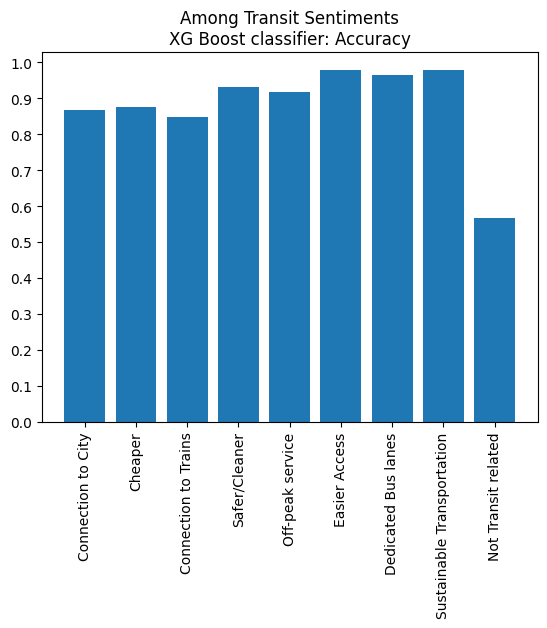

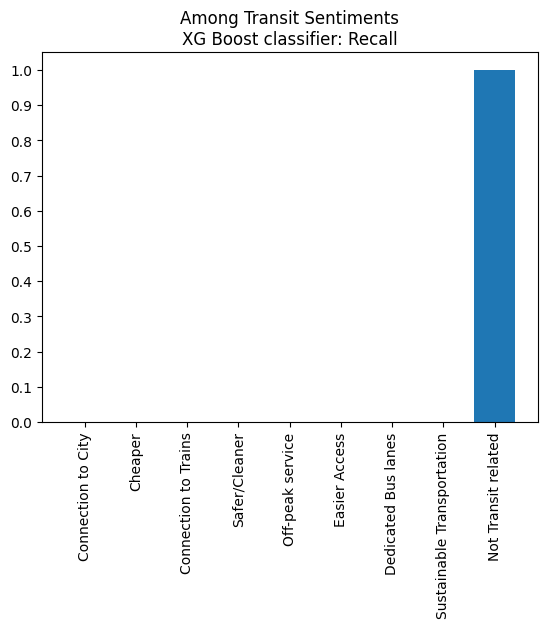

In [ ]:
accuracy={24: 0.568, 1: 0.869, 2: 0.876, 3: 0.848, 4: 0.931, 7: 0.917, 9: 0.979, 10: 0.966, 12: 0.979}
recall={24: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 7: 0.0, 9: 0.0, 10: 0.0, 12: 0.0}

list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in accuracy:
  order_val[list2d.index(item)]=accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nXG Boost classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in recall:
  order_val[list2d.index(item)]=recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nXG Boost classifier: Recall')
plt.show()
plt.clf()
plt.close()

# 2. Oversampling

We attempt some oversampling to see if we can tackle the imbalance problem.

## 2.1. Naive Bayes

In [102]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

a_line={0, 13, 14}
transit={1, 2, 3, 4, 7, 9, 10, 12}
bike_park_ride={5, 8, 11, 15}
nothing={23}


def classifyTags(tagList):
  res=[0, 0, 0, 0]
  for tag in tagList:
    res[0]+=int(tag in a_line)
    res[1]+=int(tag in transit)
    res[2]+=int(tag in bike_park_ride)
    res[3]+=int(tag in nothing)

  Res=[]
  for i, count in enumerate(res):
    if count>0:
      Res.append(i)

  return Res


NB_accuracy={}
NB_recall={}
NB_models={}

for tag in range(4):
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  ones, tot=sum(y_train_tag), len(y_train_tag)
  sampling_factor=tot//ones
  print(sampling_factor)
  y_train_tag_modified=[]
  X_train_tag_modified=[]
  for i, vect in enumerate(X_train_vect_boc):
    if y_train_tag[i]==0:
      X_train_tag_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_tag_modified.append(vect)
        y_train_tag_modified.append(1)
  clf = GaussianNB()
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  NB_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  NB_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  NB_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(NB_accuracy)
print(NB_recall)

3
2
7
4
{0: 0.36, 1: 0.523, 2: 0.784, 3: 0.534}
{0: 0.855, 1: 0.252, 2: 0.27, 3: 0.875}


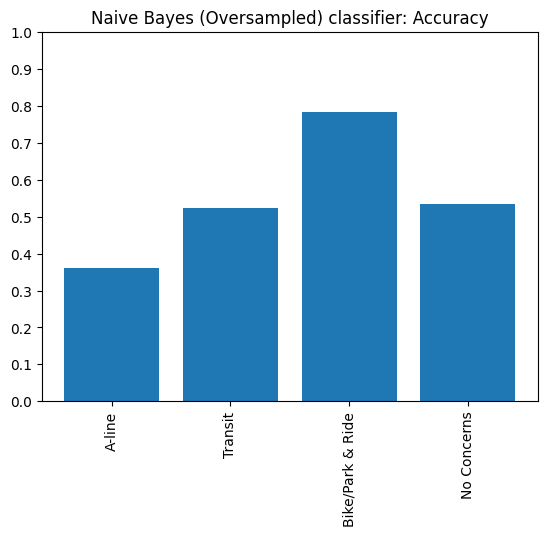

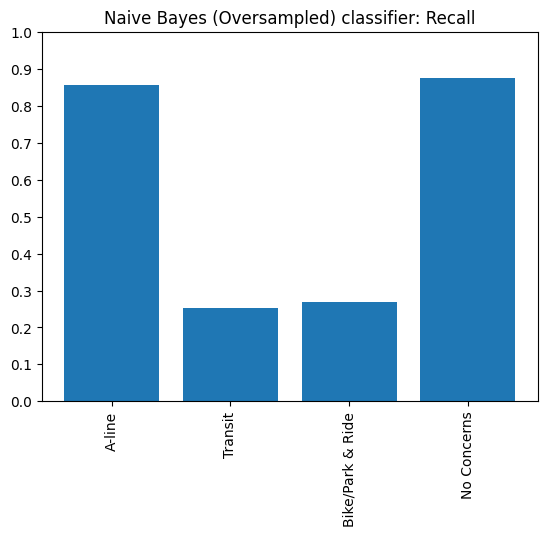

In [69]:
order_val=NB_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Oversampled) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=NB_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Naive Bayes (Oversampled) classifier: Recall')
plt.show()

## 2.2. XG Boost

In [70]:
parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [ 0.01, 0.05, 0.1, 0.5]}
XG_accuracy={}
XG_recall={}
XG_models={}

for tag in range(4):
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  ones, tot=sum(y_train_tag), len(y_train_tag)
  sampling_factor=tot//ones
  print(f'\nXGBoost Training for Tag {tag}, Oversampling factor: {sampling_factor}')
  y_train_tag_modified=[]
  X_train_tag_modified=[]
  for i, vect in enumerate(X_train_vect_boc):
    if y_train_tag[i]==0:
      X_train_tag_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_tag_modified.append(vect)
        y_train_tag_modified.append(1)
  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=5)
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  clf = clf.best_estimator_
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  XG_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  XG_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  XG_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(XG_accuracy)
print(XG_recall)


XGBoost Training for Tag 0, Oversampling factor: 3

XGBoost Training for Tag 1, Oversampling factor: 2

XGBoost Training for Tag 2, Oversampling factor: 7

XGBoost Training for Tag 3, Oversampling factor: 4
{0: 0.534, 1: 0.564, 2: 0.591, 3: 0.826}
{0: 0.79, 1: 0.969, 2: 0.486, 3: 0.833}


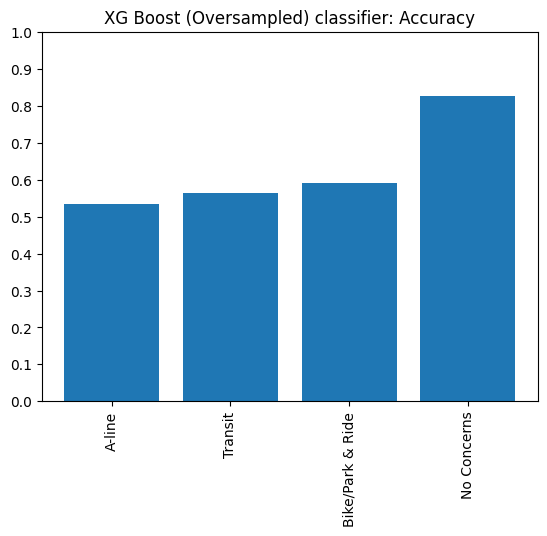

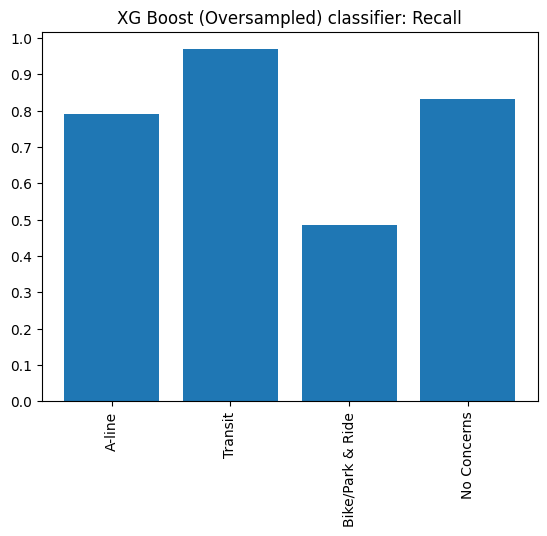

In [71]:
order_val=XG_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Oversampled) classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=XG_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('XG Boost (Oversampled) classifier: Recall')
plt.show()

## 2.3. Support Vector Machines

In [72]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(2, 11), 'C': [0.001, 0.01, 0.1, 1, 10], 'decision_function_shape': ['ovo', 'ovr']}
SVM_accuracy={}
SVM_recall={}
SVM_models={}

for tag in range(4):
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  ones, tot=sum(y_train_tag), len(y_train_tag)
  sampling_factor=tot//ones
  print(f'\nSVM Training for Tag {tag}, Oversampling factor: {sampling_factor}')
  y_train_tag_modified=[]
  X_train_tag_modified=[]
  for i, vect in enumerate(X_train_vect_boc):
    if y_train_tag[i]==0:
      X_train_tag_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_tag_modified.append(vect)
        y_train_tag_modified.append(1)
  clf = GridSearchCV(svm.SVC(), parameters, cv=5)
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  clf = clf.best_estimator_
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  SVM_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  SVM_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  SVM_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(SVM_accuracy)
print(SVM_recall)


SVM Training for Tag 0, Oversampling factor: 3

SVM Training for Tag 1, Oversampling factor: 2

SVM Training for Tag 2, Oversampling factor: 7

SVM Training for Tag 3, Oversampling factor: 4
{0: 0.564, 1: 0.504, 2: 0.386, 3: 0.765}
{0: 0.726, 1: 1.0, 2: 0.892, 3: 0.812}


In [100]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': [2, 5, 10, 20, 30], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30, 50], 'p': [1, 2]}

KNN_models={}
KNN_accuracy={}
KNN_recall={}

for tag in range(4):
  y_train_tag=[int(tag in classifyTags(item)) for item in y_train_list_boc]
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  ones, tot=sum(y_train_tag), len(y_train_tag)
  sampling_factor=tot//ones
  print(f'\nKNN Training for Tag {tag}, Oversampling factor: {sampling_factor}')
  y_train_tag_modified=[]
  X_train_tag_modified=[]
  for i, vect in enumerate(X_train_vect_boc):
    if y_train_tag[i]==0:
      X_train_tag_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_tag_modified.append(vect)
        y_train_tag_modified.append(1)
  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  clf = clf.best_estimator_
  clf.fit(X_train_tag_modified, y_train_tag_modified)
  KNN_models[tag]=clf
  y_test_pred=clf.predict(X_test_vect_boc)
  KNN_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  KNN_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

print(KNN_accuracy)
print(KNN_recall)


KNN Training for Tag 0, Oversampling factor: 3

KNN Training for Tag 1, Oversampling factor: 2

KNN Training for Tag 2, Oversampling factor: 7

KNN Training for Tag 3, Oversampling factor: 4
{0: 0.504, 1: 0.545, 2: 0.583, 3: 0.716}
{0: 0.677, 1: 0.874, 2: 0.622, 3: 0.75}



## 2.4. Choosing the best Individual models and Focusing on Transit


In [103]:
best_models={}

XG_accuracy={0: 0.534, 1: 0.564, 2: 0.591, 3: 0.826}
XG_recall={0: 0.79, 1: 0.969, 2: 0.486, 3: 0.833}

SVM_accuracy={0: 0.564, 1: 0.504, 2: 0.386, 3: 0.765}
SVM_recall={0: 0.726, 1: 1.0, 2: 0.892, 3: 0.812}

for tag in NB_accuracy:
  if tag!=24:
    maxm=[-1, float('-inf')]
    if NB_accuracy[tag]*NB_recall[tag]>maxm[1]:
      maxm=[NB_models[tag], NB_accuracy[tag]*NB_recall[tag]]
    if XG_accuracy[tag]*XG_recall[tag]>maxm[1]:
      maxm=[XG_models[tag], XG_accuracy[tag]*XG_recall[tag]]
    if SVM_accuracy[tag]*SVM_recall[tag]>maxm[1]:
      maxm=[SVM_models[tag], SVM_accuracy[tag]*SVM_recall[tag]]
    if KNN_accuracy[tag]*KNN_recall[tag]>maxm[1]:
      maxm=[KNN_models[tag], KNN_accuracy[tag]*KNN_recall[tag]]
    best_models[tag]=maxm

best_models

{0: [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.01, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, random_state=42, ...),
  0.42186000000000007],
 1: [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_ro

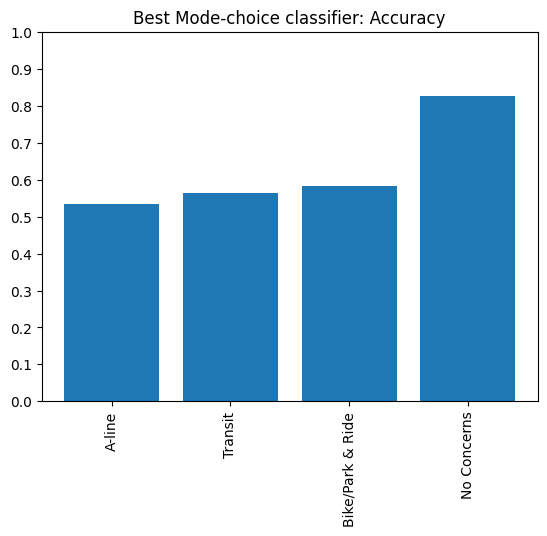

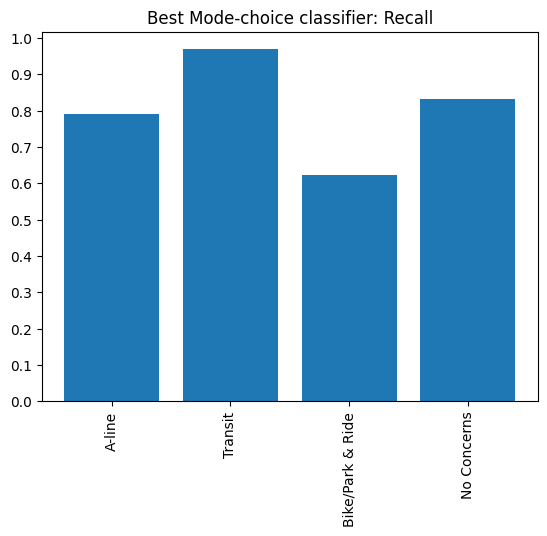

In [104]:
modechoice_accuracy={}
modechoice_recall={}

for tag in range(4):
  y_test_true=[int(tag in classifyTags(item)) for item in y_test_list_boc]
  y_test_pred=best_models[tag][0].predict(X_test_vect_boc)
  modechoice_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  modechoice_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

order_val=modechoice_accuracy.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Best Mode-choice classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val=modechoice_recall.copy()
plt.bar(*zip(*order_val.items()))
plt.xticks(range(4), ['A-line', 'Transit', 'Bike/Park & Ride', 'No Concerns'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Best Mode-choice classifier: Recall')
plt.show()

### 2.4.1. Focusing on Transit: Naive Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

transit={1, 2, 3, 4, 7, 9, 10, 12}

NB_accuracy={}
NB_recall={}
NB_transit_models={}
X_train_transit=[]
y_train_transit_list=[]
for i, vect in enumerate(X_train_vect_boc):
  chosen=[]
  tags=y_train_list_boc[i]
  for tag in tags:
    if tag in transit:
      chosen.append(tag)
  if chosen:
    X_train_transit.append(vect)
    y_train_transit_list.append(chosen)

y_pred_transit=best_models[1][0].predict(X_test_vect_boc)


def isTransit(tags):
  filterlist=[]
  for tag in tags:
    if tag in transit:
      filterlist.append(tag)
  return filterlist

X_test_transit=[]
y_test_transit_true=[]
y_test_nottransit_true=[]
for i, vect in enumerate(X_test_vect_boc):
  if y_pred_transit[i]==1:
    X_test_transit.append(vect)
    y_test_transit_true.append(isTransit(y_test_list_boc[i]))
  else:
    y_test_nottransit_true.append(0 if isTransit(y_test_list_boc[i])!=[] else 1)

NB_recall[24]=round(recall_score(y_test_nottransit_true, [1]*len(y_test_nottransit_true)), 3)
NB_accuracy[24]=round(accuracy_score(y_test_nottransit_true, [1]*len(y_test_nottransit_true)), 3)

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  sampling_factor=len(y_train_tag)//sum(y_train_tag)

  y_train_tag_modified=[]
  X_train_transit_modified=[]
  for i, vect in enumerate(X_train_transit):
    if y_train_tag[i]==0:
      X_train_transit_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_transit_modified.append(vect)
        y_train_tag_modified.append(1)

  clf = GaussianNB()
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  NB_transit_models[tag]=clf
  y_test_pred=clf.predict(X_test_transit)
  NB_recall[tag]=round(recall_score(y_test_true, y_test_pred), 3)
  NB_accuracy[tag]=round(accuracy_score(y_test_true, y_test_pred), 3)

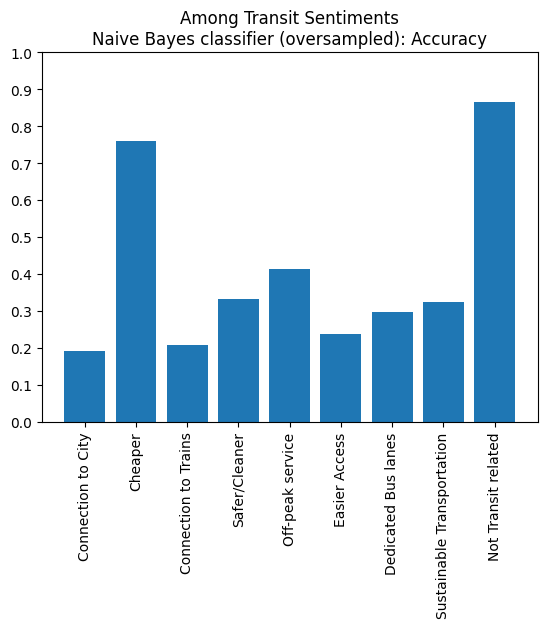

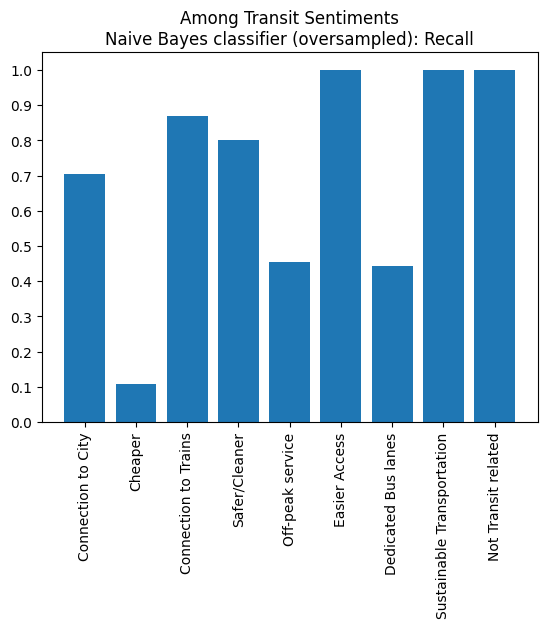

In [77]:
list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in NB_accuracy:
  order_val[list2d.index(item)]=NB_accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNaive Bayes classifier (oversampled): Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in NB_recall:
  order_val[list2d.index(item)]=NB_recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNaive Bayes classifier (oversampled): Recall')
plt.show()
plt.clf()
plt.close()

### 2.4.2. Focusing on Transit: XG Boost

In [78]:
parameters={'max_depth': [3, 5, 7, 11], 'n_estimators': [50, 100, 150], 'learning_rate': [ 0.01, 0.05, 0.1, 0.5]}
XG_transit_models={}
XG_accuracy={24: NB_accuracy[24]}
XG_recall={24: NB_recall[24]}

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  sampling_factor=len(y_train_tag)//sum(y_train_tag)
  print(f'\nXGBoost Traning for Transit Tag {tag}, Oversampling factor={sampling_factor}')

  y_train_tag_modified=[]
  X_train_transit_modified=[]
  for i, vect in enumerate(X_train_transit):
    if y_train_tag[i]==0:
      X_train_transit_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_transit_modified.append(vect)
        y_train_tag_modified.append(1)

  clf=GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=42), parameters, cv=5)
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  clf=clf.best_estimator_
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  XG_transit_models[tag]=clf
  y_test_pred=clf.predict(X_test_transit)
  rec=round(recall_score(y_test_true, y_test_pred), 3)
  XG_recall[tag]=rec
  acc=round(accuracy_score(y_test_true, y_test_pred), 3)
  XG_accuracy[tag]=acc
  print(acc, rec)


XGBoost Traning for Transit Tag 1, Oversampling factor=3
0.534 0.444

XGBoost Traning for Transit Tag 2, Oversampling factor=4
0.436 0.571

XGBoost Traning for Transit Tag 3, Oversampling factor=4
0.692 0.174

XGBoost Traning for Transit Tag 4, Oversampling factor=7
0.825 0.267

XGBoost Traning for Transit Tag 7, Oversampling factor=10
0.825 0.091

XGBoost Traning for Transit Tag 9, Oversampling factor=11
0.897 0.0

XGBoost Traning for Transit Tag 10, Oversampling factor=12
0.91 0.111

XGBoost Traning for Transit Tag 12, Oversampling factor=15
0.919 0.429


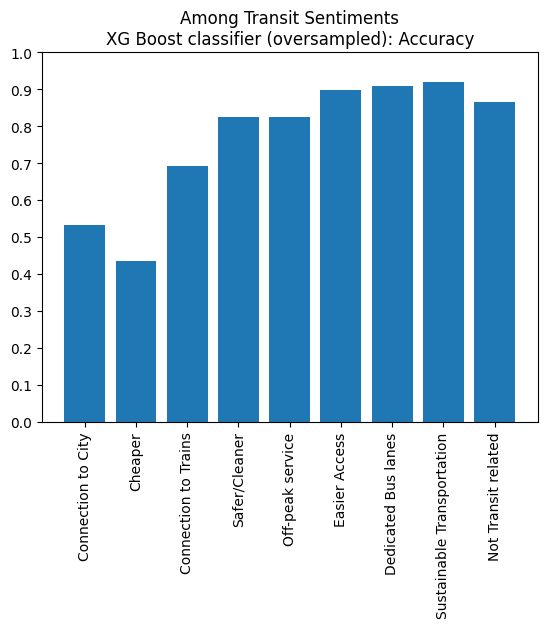

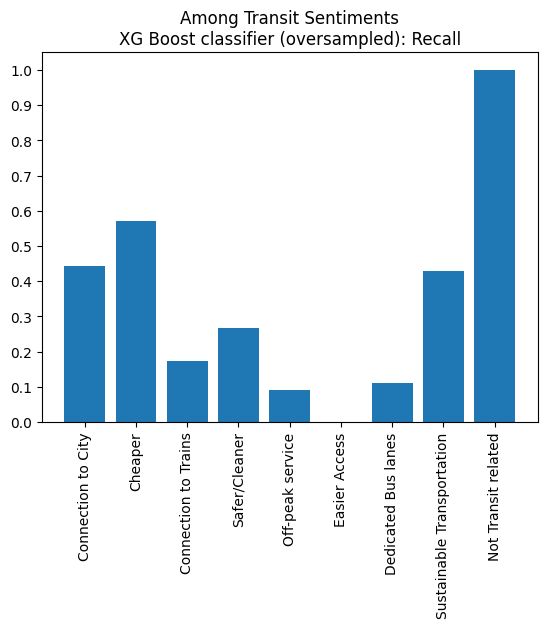

In [79]:
list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in XG_accuracy:
  order_val[list2d.index(item)]=XG_accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nXG Boost classifier (oversampled): Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in XG_recall:
  order_val[list2d.index(item)]=XG_recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nXG Boost classifier (oversampled): Recall')
plt.show()
plt.clf()
plt.close()

### 2.4.3. Focusing on Transit: Neural Network

In [80]:
from sklearn.neural_network import MLPClassifier

parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
MLP_transit_models={}
MLP_accuracy={24: NB_accuracy[24]}
MLP_recall={24: NB_recall[24]}

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  sampling_factor=len(y_train_tag)//sum(y_train_tag)
  print(f'\nNeural Network Traning for Transit Tag {tag}, Oversampling factor={sampling_factor}')

  y_train_tag_modified=[]
  X_train_transit_modified=[]
  for i, vect in enumerate(X_train_transit):
    if y_train_tag[i]==0:
      X_train_transit_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_transit_modified.append(vect)
        y_train_tag_modified.append(1)

  clf = GridSearchCV(MLPClassifier(max_iter=2000, random_state=42, learning_rate='adaptive', solver='lbfgs', warm_start=True), parameters, cv=5)
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  clf=clf.best_estimator_
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  MLP_transit_models[tag]=clf
  y_test_pred=clf.predict(X_test_transit)
  rec=round(recall_score(y_test_true, y_test_pred), 3)
  MLP_recall[tag]=rec
  acc=round(accuracy_score(y_test_true, y_test_pred), 3)
  MLP_accuracy[tag]=acc
  print(acc, rec)


Neural Network Traning for Transit Tag 1, Oversampling factor=3
0.637 0.222

Neural Network Traning for Transit Tag 2, Oversampling factor=4
0.53 0.464

Neural Network Traning for Transit Tag 3, Oversampling factor=4
0.701 0.0

Neural Network Traning for Transit Tag 4, Oversampling factor=7
0.791 0.267

Neural Network Traning for Transit Tag 7, Oversampling factor=10
0.838 0.0

Neural Network Traning for Transit Tag 9, Oversampling factor=11
0.876 0.0

Neural Network Traning for Transit Tag 10, Oversampling factor=12
0.889 0.111

Neural Network Traning for Transit Tag 12, Oversampling factor=15
0.645 0.429


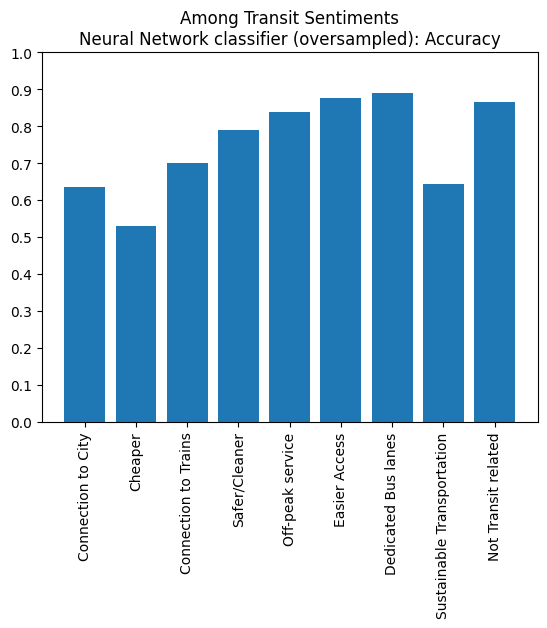

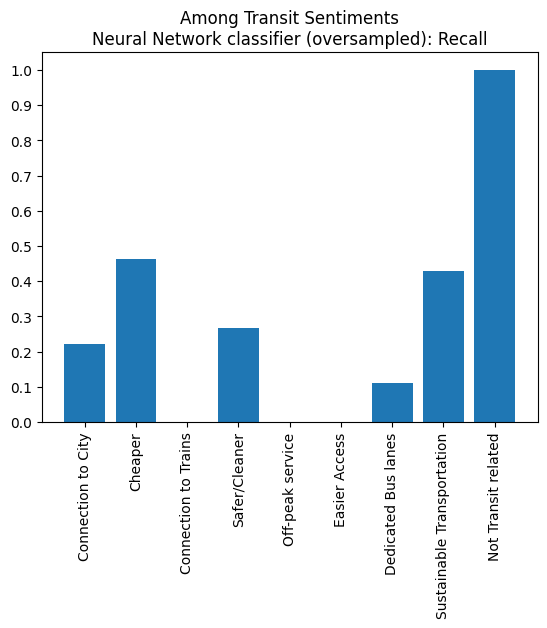

In [81]:
list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in MLP_accuracy:
  order_val[list2d.index(item)]=MLP_accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNeural Network classifier (oversampled): Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in MLP_recall:
  order_val[list2d.index(item)]=MLP_recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nNeural Network classifier (oversampled): Recall')
plt.show()
plt.clf()
plt.close()

### 2.4.4. Focusing on Transit: Support Vector Machines

In [82]:
from sklearn import svm

parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(2, 11), 'C': [0.001, 0.01, 0.1, 1, 10], 'decision_function_shape': ['ovo', 'ovr'],}
SVM_transit_models={}
SVM_accuracy={24: NB_accuracy[24]}
SVM_recall={24: NB_recall[24]}

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  sampling_factor=len(y_train_tag)//sum(y_train_tag)
  print(f'\nSVM Training for Transit Tag {tag}, Oversampling factor={sampling_factor}')

  y_train_tag_modified=[]
  X_train_transit_modified=[]
  for i, vect in enumerate(X_train_transit):
    if y_train_tag[i]==0:
      X_train_transit_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_transit_modified.append(vect)
        y_train_tag_modified.append(1)

  clf = GridSearchCV(svm.SVC(), parameters, cv=5)
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  clf=clf.best_estimator_
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  SVM_transit_models[tag]=clf
  y_test_pred=clf.predict(X_test_transit)
  rec=round(recall_score(y_test_true, y_test_pred), 3)
  SVM_recall[tag]=rec
  acc=round(accuracy_score(y_test_true, y_test_pred), 3)
  SVM_accuracy[tag]=acc
  print(acc, rec)


SVM Training for Transit Tag 1, Oversampling factor=3
0.645 0.407

SVM Training for Transit Tag 2, Oversampling factor=4
0.286 0.929

SVM Training for Transit Tag 3, Oversampling factor=4
0.688 0.391

SVM Training for Transit Tag 4, Oversampling factor=7
0.714 0.467

SVM Training for Transit Tag 7, Oversampling factor=10
0.641 0.364

SVM Training for Transit Tag 9, Oversampling factor=11
0.517 0.556

SVM Training for Transit Tag 10, Oversampling factor=12
0.594 0.556

SVM Training for Transit Tag 12, Oversampling factor=15
0.812 0.571


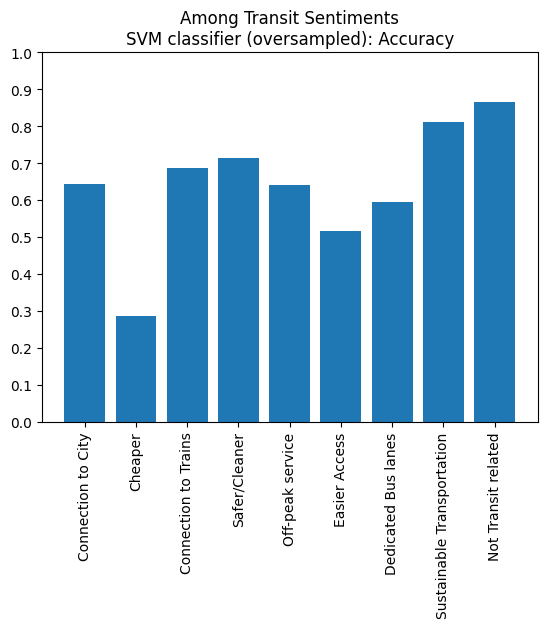

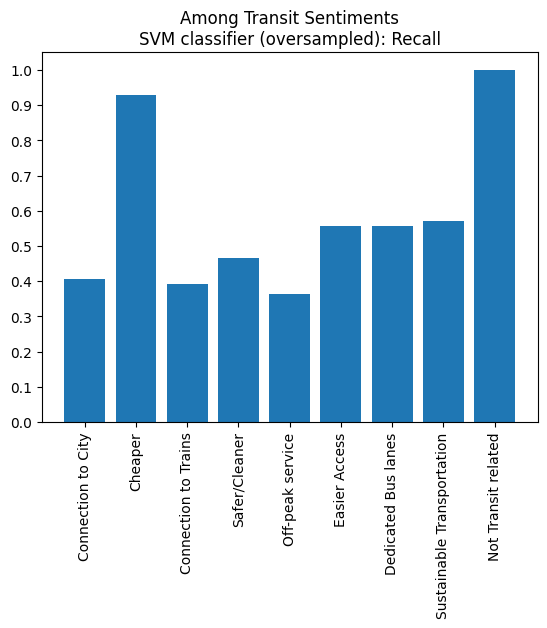

In [83]:
list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in SVM_accuracy:
  order_val[list2d.index(item)]=SVM_accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nSVM classifier (oversampled): Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in SVM_recall:
  order_val[list2d.index(item)]=SVM_recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nSVM classifier (oversampled): Recall')
plt.show()
plt.clf()
plt.close()

In [96]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': [2, 5, 10, 20, 30], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [20, 30, 50], 'p': [1, 2]}

KNN_transit_models={}
KNN_accuracy={24: NB_accuracy[24]}
KNN_recall={24: NB_recall[24]}

for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_train_tag=[int(tag in item) for item in y_train_transit_list]
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  sampling_factor=len(y_train_tag)//sum(y_train_tag)
  print(f'\nKNN Training for Transit Tag {tag}, Oversampling factor={sampling_factor}')

  y_train_tag_modified=[]
  X_train_transit_modified=[]
  for i, vect in enumerate(X_train_transit):
    if y_train_tag[i]==0:
      X_train_transit_modified.append(vect)
      y_train_tag_modified.append(0)
    else:
      for j in range(sampling_factor):
        X_train_transit_modified.append(vect)
        y_train_tag_modified.append(1)

  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  clf=clf.best_estimator_
  clf.fit(X_train_transit_modified, y_train_tag_modified)
  KNN_transit_models[tag]=clf
  y_test_pred=clf.predict(X_test_transit)
  recall, accuracy=round(recall_score(y_test_true, y_test_pred), 3), round(accuracy_score(y_test_true, y_test_pred), 3)
  print(recall, accuracy)
  KNN_recall[tag]=recall
  KNN_accuracy[tag]=accuracy

print(KNN_accuracy)
print(KNN_recall)


KNN Training for Transit Tag 1, Oversampling factor=3
0.37 0.491

KNN Training for Transit Tag 2, Oversampling factor=4
0.607 0.462

KNN Training for Transit Tag 3, Oversampling factor=4
0.609 0.551

KNN Training for Transit Tag 4, Oversampling factor=7
0.667 0.491

KNN Training for Transit Tag 7, Oversampling factor=10
0.545 0.59

KNN Training for Transit Tag 9, Oversampling factor=11
0.333 0.564

KNN Training for Transit Tag 10, Oversampling factor=12
0.222 0.906

KNN Training for Transit Tag 12, Oversampling factor=15
0.714 0.688
{24: 0.867, 1: 0.491, 2: 0.462, 3: 0.551, 4: 0.491, 7: 0.59, 9: 0.564, 10: 0.906, 12: 0.688}
{24: 1.0, 1: 0.37, 2: 0.607, 3: 0.609, 4: 0.667, 7: 0.545, 9: 0.333, 10: 0.222, 12: 0.714}


### 2.4.5. Focusing on Transit: Choosing the best model for each Tag

In [97]:
best_transit_models={}

for tag in NB_accuracy:
  if tag!=24:
    maxm=[-1, float('-inf')]
    if NB_accuracy[tag]*NB_recall[tag]>maxm[1]:
      maxm=[NB_transit_models[tag], NB_accuracy[tag]*NB_recall[tag]]
    if XG_accuracy[tag]*XG_recall[tag]>maxm[1]:
      maxm=[XG_transit_models[tag], XG_accuracy[tag]*XG_recall[tag]]
    if MLP_accuracy[tag]*MLP_recall[tag]>maxm[1]:
      maxm=[MLP_transit_models[tag], MLP_accuracy[tag]*MLP_recall[tag]]
    if SVM_accuracy[tag]*SVM_recall[tag]>maxm[1]:
      maxm=[SVM_transit_models[tag], SVM_accuracy[tag]*SVM_recall[tag]]
    if KNN_accuracy[tag]*KNN_recall[tag]>maxm[1]:
      maxm=[KNN_transit_models[tag], KNN_accuracy[tag]*KNN_recall[tag]]
    best_transit_models[tag]=maxm

best_transit_models

{1: [SVC(C=1, decision_function_shape='ovo', degree=2), 0.262515],
 2: [KNeighborsClassifier(leaf_size=50, n_neighbors=30), 0.280434],
 3: [KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, n_neighbors=30),
  0.335559],
 4: [SVC(C=10, decision_function_shape='ovo', degree=2), 0.333438],
 7: [KNeighborsClassifier(leaf_size=20, n_neighbors=20), 0.32155],
 9: [SVC(C=10, decision_function_shape='ovo', degree=2, kernel='sigmoid'),
  0.28745200000000004],
 10: [SVC(C=0.1, decision_function_shape='ovo', degree=2, kernel='linear'),
  0.330264],
 12: [KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1),
  0.49123199999999995]}

In [98]:
transit_accuracy={24: NB_accuracy[24]}
transit_recall={24: NB_recall[24]}
true_count={}
pred_count={}
for tag in [1, 2, 3, 4, 7, 9, 10, 12]:
  y_test_true=[int(tag in item) for item in y_test_transit_true]
  y_test_pred=best_transit_models[tag][0].predict(X_test_transit)
  rec=round(recall_score(y_test_true, y_test_pred), 3)
  transit_recall[tag]=rec
  acc=round(accuracy_score(y_test_true, y_test_pred), 3)
  transit_accuracy[tag]=acc

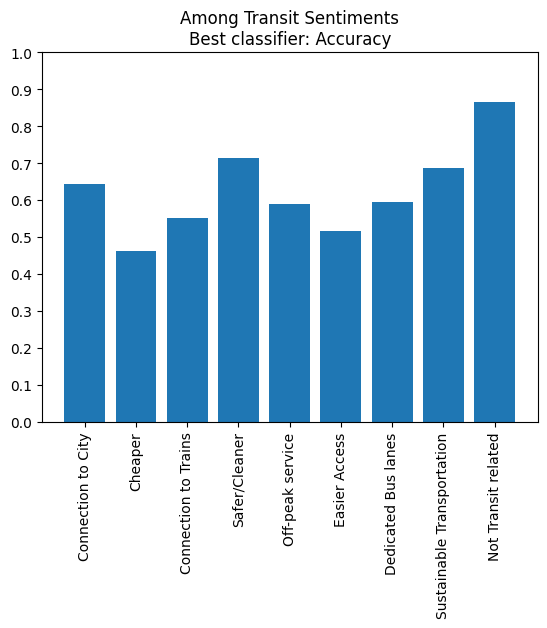

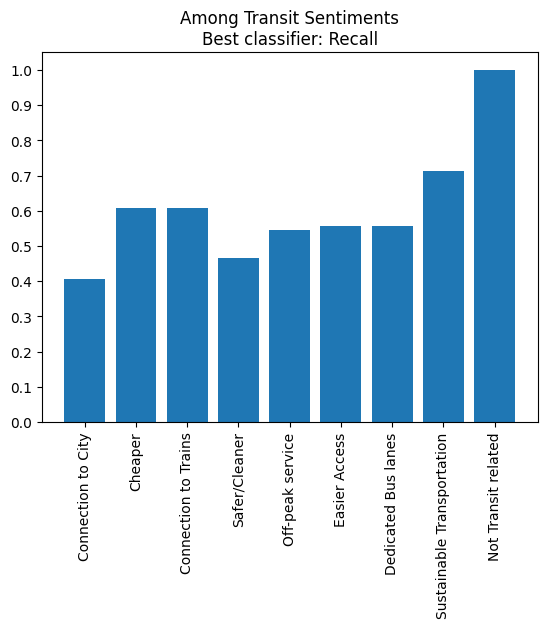

In [99]:
list2d=[1, 2, 3, 4, 7, 9, 10, 12, 24]

order_val={}
for item in transit_accuracy:
  order_val[list2d.index(item)]=transit_accuracy[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nBest classifier: Accuracy')
plt.show()
plt.clf()
plt.close()
print('\n')

order_val={}
for item in transit_recall:
  order_val[list2d.index(item)]=transit_recall[item]
plt.bar(*zip(*order_val.items()))
plt.xticks(range(9), ['Connection to City', 'Cheaper', 'Connection to Trains', 'Safer/Cleaner', 'Off-peak service', 'Easier Access', 'Dedicated Bus lanes', 'Sustainable Transportation', 'Not Transit related'], rotation=90, fontsize=10)
plt.yticks([i*0.1 for i in range(11)])
plt.title('Among Transit Sentiments\nBest classifier: Recall')
plt.show()
plt.clf()
plt.close()